# Self-Driving Car Engineer Nanodegree


## Project2: ** Advanced Lane Finding** 

** Solution by luk6xff (May 2019)
** Writeup here: [P2 writeup](WRITEUP.md)

### In this project, a goal is to write a software pipeline to identify the lane boundaries in a video.

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Packages

In [2]:
# Importing some useful packages used in the project
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## 1. Camera calibration and distortion coefficients 

Camera intrinsic matrix:
[[  1.15777942e+03   0.00000000e+00   6.67111049e+02]
 [  0.00000000e+00   1.15282305e+03   3.86129069e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Camera distortion coefficients:
[[-0.24688833 -0.02372814 -0.00109843  0.00035105 -0.00259138]]


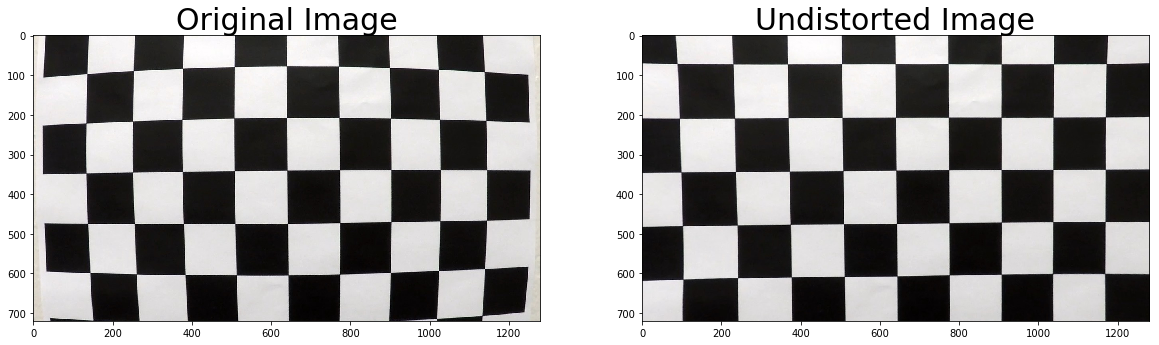

In [3]:
def calibrate_camera(images, nx, ny, img_size):
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    #print(objp[:,:2])
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), cv2.CALIB_CB_ADAPTIVE_THRESH)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            # Save the images
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            #cols = 8
            #rows = 1
            #plt.figure(figsize=(50,70))
            #plt.subplot(cols, rows, (idx%8)+1)
            #plt.imshow(img)
    # Do camera calibration given object points and image points
    ret, cam_mtx, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return cam_mtx, dist_coeffs



def undistort_image(img, cam_mtx, dist_coeffs):
    return cv2.undistort(img, cam_mtx, dist_coeffs, None, cam_mtx)


############### TESTS ############### 
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Based on used images (camera_cal/calibration*.jpg), I set the number of corners
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# Test image
img      = cv2.imread('camera_cal/calibration1.jpg')
img      = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])


cam_mtx, dist_coeffs = calibrate_camera(images, nx, ny, img_size)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
# cam_mtx     = [fx  0  cx]
#               [0  fy  cy]
#               [0   0   1]
# dist_coeffs = [k1, k2, p1, p2, k3]

######################## CAMERA_PICKLE ########################
# CREATE AND SAVE CAMERA PICKLE FOR LATER USAGE ###########
cam_pickle = {}
cam_pickle["cam_mtx"] = cam_mtx
cam_pickle["dist_coeffs"] = dist_coeffs
print('Camera intrinsic matrix:\n{}'.format(cam_mtx))
print('Camera distortion coefficients:\n{}'.format(dist_coeffs))
pickle.dump(cam_pickle, open("camera_cal/camera_calib_pickle.p", "wb" ))
######################## CAMERA_PICKLE ########################

# Undistort image
undistorted_img = undistort_image(img, cam_mtx, dist_coeffs)
###### Debug save
cv2.imwrite('output_images/distorted_image.png', img)
cv2.imwrite('output_images/undistorted_image.png', undistorted_img)

# Print the calibration results - original (distorted) image, and undistorted one.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=30)

## 2. Use color transforms, gradients, etc., to create a thresholded binary image.

True

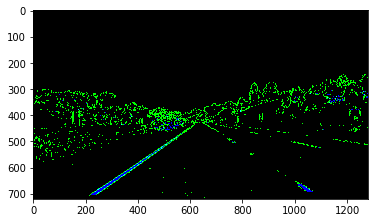

In [4]:
def apply_threshold(img, grad_thresh=(20,100), s_color_thresh=(180,255)):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2] #Saturation channel
    
    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv_h_channel = hsv[:,:,0]
    hsv_s_channel = hsv[:,:,1]
    hsv_v_channel = hsv[:,:,2]

    # Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Find sobel gradient
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobel_x  = np.absolute(sobel_x)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    
    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= grad_thresh[0]) & (scaled_sobel <= grad_thresh[1])] = 1
    
    # Threshold s color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_color_thresh[0]) & (s_channel <= s_color_thresh[1])] = 1
    
    # Threshold l color channel
    #l_binary = np.zeros_like(hsv_s_channel)
    #l_binary[(hsv_s_channel >= l_color_thresh[0]) & (hsv_s_channel <= l_color_thresh[1])] = 1
    
    #plt.imshow(s_binary)
    
    # Stack each channel
    color_binary = np.dstack((np.zeros_like(sx_binary), sx_binary, s_binary))*255
    
    # apply a light morphology to "fill the gaps" in the binary image
    #kernel = np.ones((3, 3), np.uint8)
    #color_binary = cv2.morphologyEx(color_binary.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    plt.imshow(color_binary)
    return color_binary

############### TESTS ###############
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary_img = apply_threshold(undistorted_img)
###### Debug save
cv2.imwrite('output_images/undistorted_threshlded_image.png', binary_img)
#plt.imshow(binary_img)

## 3. Apply a perspective transform to rectify binary image ("birds-eye view" or "top-down- view).

(1280, 720)


True

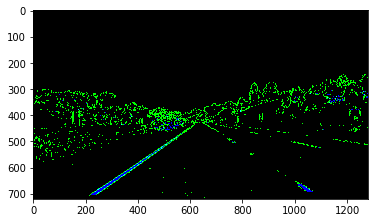

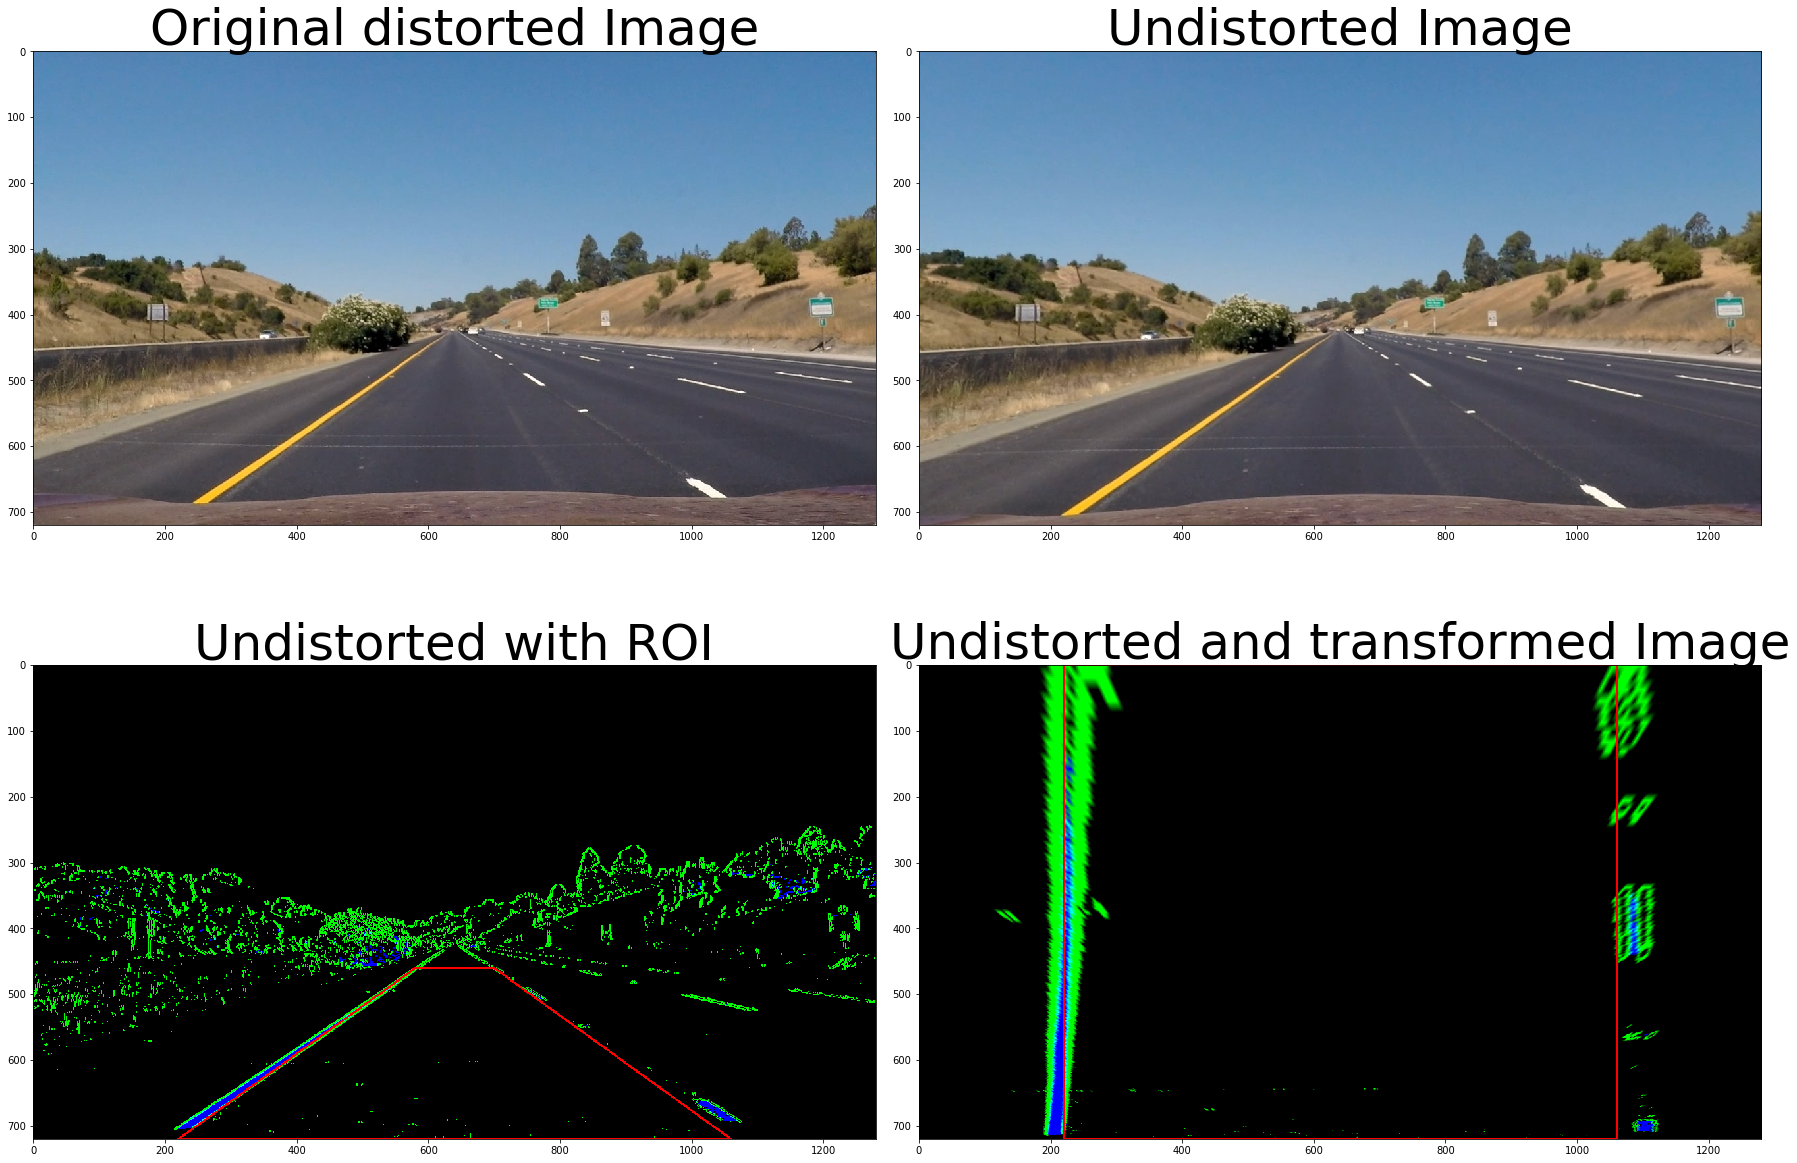

In [7]:
def top_down_view(img):
    img_size = (img.shape[1], img.shape[0])
    print(img_size)
    # 2) Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # For source points i pick the points describing trapezoid as shown below
    # Setup: x_center=640, x_offset_top=420, x_offset_bottom=60, y_top=720, y_bottom=460
    x_center=640
    x_offset_top=420
    x_offset_bottom=60
    y_top=img_size[1]#720
    y_bottom=460
    src = np.float32([[x_center+x_offset_bottom,y_bottom],
                      [x_center+x_offset_top,y_top],
                      [x_center-x_offset_top,y_top],
                      [x_center-x_offset_bottom,y_bottom]])
    # 4 destination points dst = np.float32([[,],[,],[,],[,]])
    # For destination points I am taking the image size to map trapezoid on lines (starting from top-left corner)
    # + add small offset to get some offset in the image
    # Values have been chosen after analysing images

    dst = np.float32([[x_center+x_offset_top,0],
                      [x_center+x_offset_top,img_size[1]],
                      [x_center-x_offset_top,img_size[1]],
                      [x_center-x_offset_top,0]])
    
    # Use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Draw src and dst guide lines on both images
    img_with_roi = cv2.polylines(img, np.int32([src]), True, (255,0,0), 2)
    warped = cv2.polylines(warped, np.int32([dst]), True, (255,0,0), 2)
    
    return img_with_roi, warped, Minv


############################## TESTS ##############################
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary = apply_threshold(undistorted_img)
img_with_roi, transformed_top_down_img, inv_perspective_matrix = top_down_view(binary)

######################## CAMERA_PICKLE ########################
# UPDATE CAMERA PICKLE FOR LATER USAGE
cam_pickle = pickle.load(open("camera_cal/camera_calib_pickle.p", "rb") )
cam_pickle["inv_perspective_matrix"] = inv_perspective_matrix
pickle.dump(cam_pickle, open("camera_cal/camera_calib_pickle.p", "wb" ))
######################## CAMERA_PICKLE ########################

# Plots
f, (p1, p2) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
p1[0].imshow(image)
p1[0].set_title('Original distorted Image', fontsize=50)
p1[1].imshow(undistorted_img)
p1[1].set_title('Undistorted Image', fontsize=50)
p2[0].imshow(img_with_roi)
p2[0].set_title('Undistorted with ROI', fontsize=50)
p2[1].imshow(transformed_top_down_img)
p2[1].set_title('Undistorted and transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=1.8, bottom=0.)

###### Debug save
cv2.imwrite('output_images/undistorted_with_ROI.png', img_with_roi)
cv2.imwrite('output_images/undistorted_and_transformed_image.png', transformed_top_down_img)

## 4. Detect lane pixels and fit to find the lane boundary.

(1280, 720)


True

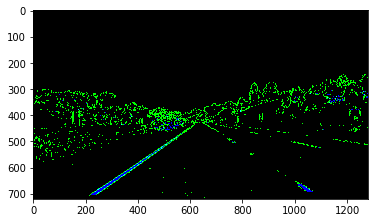

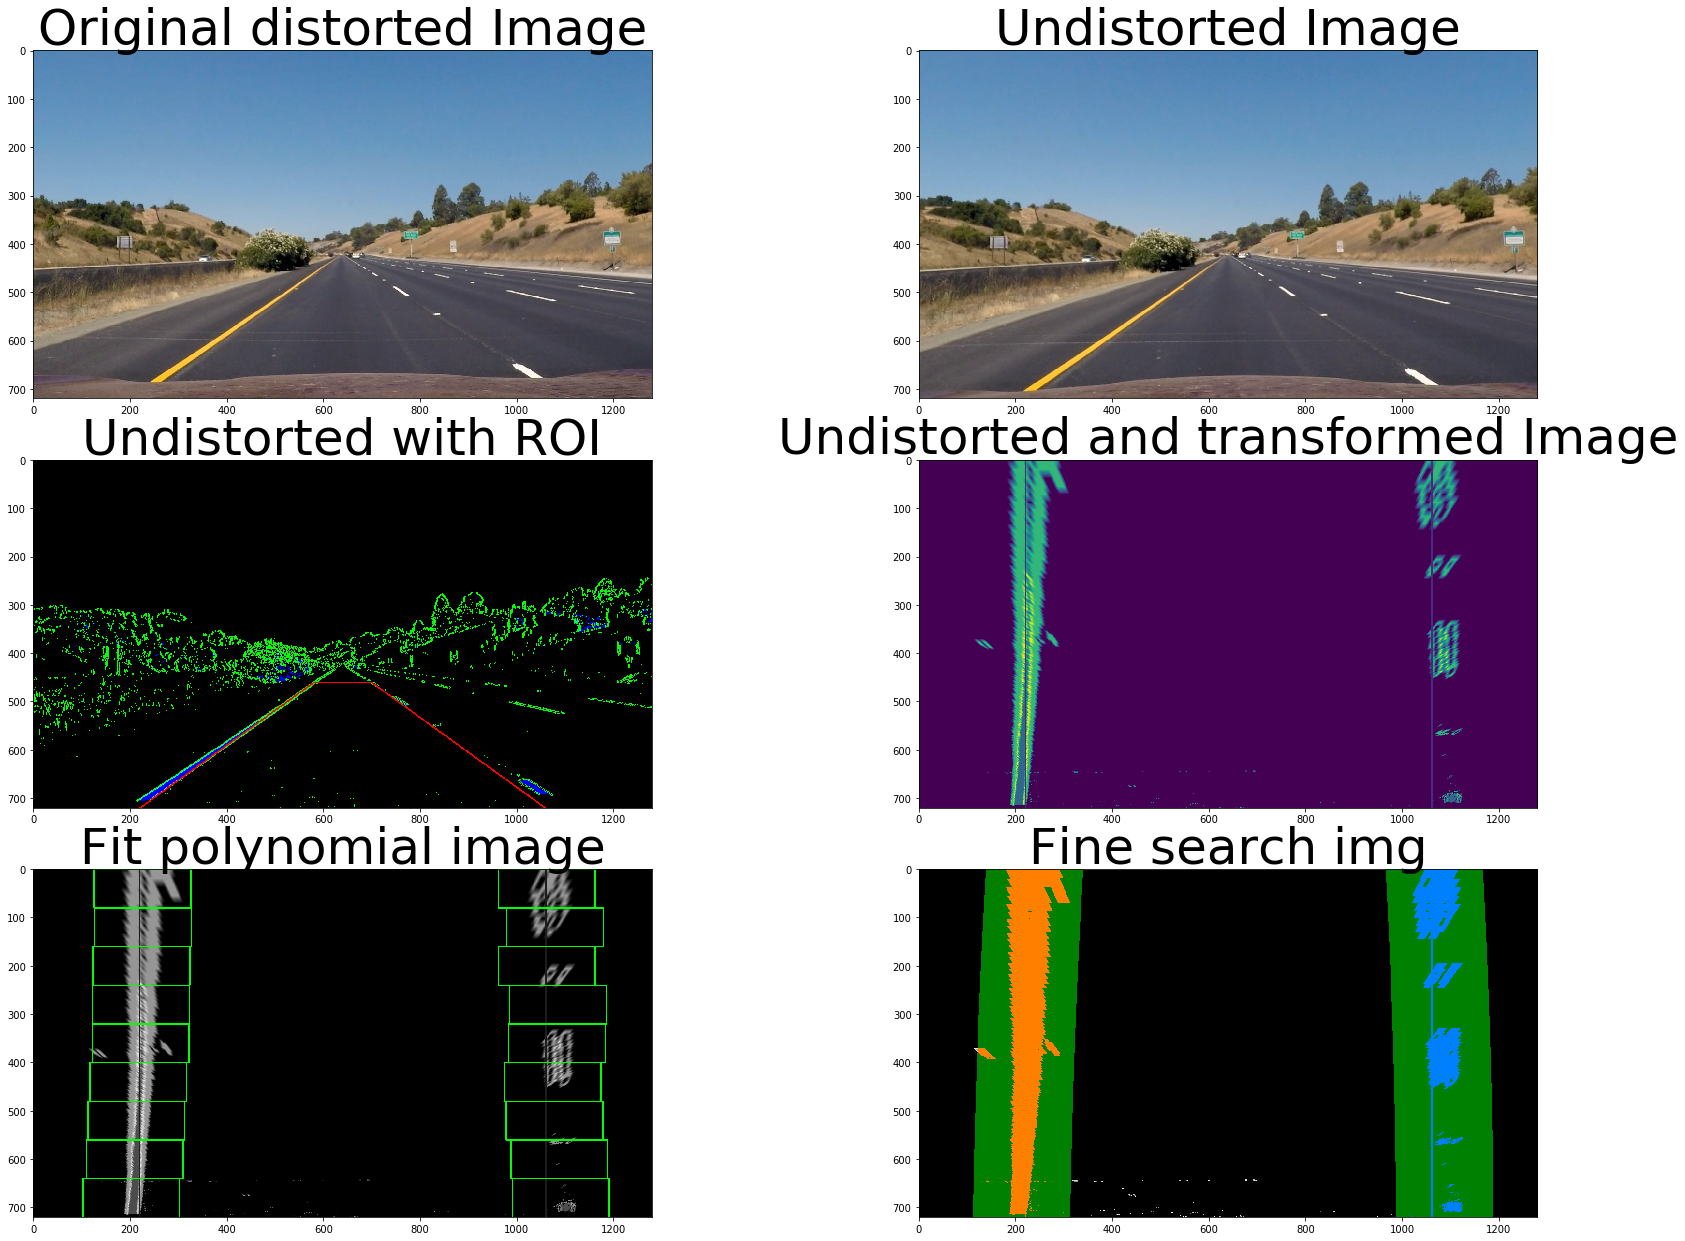

In [8]:
def find_lane_coarse(binary_warped_img):
    '''
    Find the lines with Sliding windows method
    '''
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped_img[binary_warped_img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 30

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped_img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped_img.shape[0] - (window+1)*window_height
        win_y_high = binary_warped_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img




def fit_polynomial(binary_warped_img, leftx, lefty, rightx, righty):
    """
    Fits a polynomial to all relevant pixels we have found in our sliding windows 
    """
    visualize = False

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped_img.shape[0]-1, binary_warped_img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization of the polynomial ##
    if visualize:
        # Colors in the left and right lane regions
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))*255
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        

    return left_fitx, right_fitx, ploty




def find_lane_fine(binary_warped_img, left_fit, right_fit):
    """
    Set the area to search for activated pixels based on margin
    With a previous set of lane fit parameters in pixel space, search in the neighbourhood 
    and return updated lane pixel vectors
    """
    # The width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ## Visualization ##    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))*255
    window_img = np.zeros_like(out_img)
    
    # Check in case if no pixels were found
    if leftx.size == 0 or rightx.size == 0:
        return False, leftx, lefty, rightx, righty, out_img

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_polynomial(binary_warped_img, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result_img = cv2.addWeighted(out_img, 1, window_img, 0.5, 0)
    
    ###### Debug save
    # Plot the polynomial lines onto the image
    #     plt.imshow(result_img)
    #     plt.plot(left_fitx, ploty, color='yellow')
    #     plt.plot(right_fitx, ploty, color='yellow')
    #     plt.savefig('output_images/polynomial_line.png')
    ## End visualization steps ##
    
    return True, leftx, lefty, rightx, righty, result_img



############### TESTS ###############
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary = apply_threshold(undistorted_img)
img_with_roi, transformed_top_down_img, inv_perspective_matrix = top_down_view(binary)

binary_top_down = cv2.cvtColor(transformed_top_down_img, cv2.COLOR_BGR2GRAY)
# Find lane pixels first
leftx, lefty, rightx, righty, out_img = find_lane_coarse(binary_top_down)

# Fit a second order polynomial to lane pixels
left_fit  = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

found, leftx, lefty, rightx, righty, fine_search_img = find_lane_fine(binary_top_down, left_fit, right_fit)

# Plots
f, (p0, p1, p2) = plt.subplots(3, 2, figsize=(24, 9))
f.tight_layout()
p0[0].imshow(image)
p0[0].set_title('Original distorted Image', fontsize=50)
p0[1].imshow(undistorted_img)
p0[1].set_title('Undistorted Image', fontsize=50)
p1[0].imshow(img_with_roi)
p1[0].set_title('Undistorted with ROI', fontsize=50)
p1[1].imshow(binary_top_down)
p1[1].set_title('Undistorted and transformed Image', fontsize=50)
p2[0].imshow(out_img)
p2[0].set_title('Fit polynomial image', fontsize=50)
p2[1].imshow(fine_search_img)
p2[1].set_title('Fine search img', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=1.8, bottom=0.)


###### Debug save
cv2.imwrite('output_images/sliding_windows.png', out_img)

## 5. Determine the curvature of the lane and vehicle position with respect to center.

(1280, 720)
Road curvature radius:  1485.60631574 m.
Vehicle offset from center: -0.0406655555197 m.


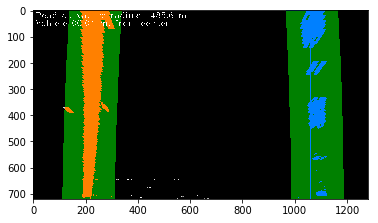

In [9]:
# Define conversions in x and y from pixels space to meters according to 
# http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC
ym_per_pix = 3.05/150 # meters per pixel in y dimension (Dashed line is 3.05 meters long)
xm_per_pix = 3.7/860 # meters per pixel in x dimension  (Lane is 3.7m wide)
######################## CAMERA_PICKLE ########################
# UPDATE CAMERA PICKLE FOR LATER USAGE
cam_pickle = pickle.load(open("camera_cal/camera_calib_pickle.p", "rb") )
cam_pickle["ym_per_pix"] = ym_per_pix
cam_pickle["xm_per_pix"] = xm_per_pix
pickle.dump(cam_pickle, open("camera_cal/camera_calib_pickle.p", "wb" ))
######################## CAMERA_PICKLE ########################


# Return curvature evaluated at y_eval
def get_curvature(left_fit, right_fit, y_eval):
    left_radius  = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_radius = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return (left_radius + right_radius)/2

# Return vehicle offset from center. > 0 if vehicle is offset to the right of center
def get_offset_from_center(left_fit, right_fit, x_mid, y_eval):
    left_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    x = (left_x + right_x)/2
    return x_mid - x


############### TESTS ###############
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary = apply_threshold(undistorted_img)
img_with_roi, transformed_top_down_img, inv_perspective_matrix = top_down_view(binary)
binary_top_down = cv2.cvtColor(transformed_top_down_img, cv2.COLOR_BGR2GRAY)
# Find lane pixels first (coarse)
leftx, lefty, rightx, righty, out_img = find_lane_coarse(binary_top_down)

# Fit a second order polynomial to lane pixels
left_fit  = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Find lane pixels (fine)
found, leftx, lefty, rightx, righty, fine_search_img = find_lane_fine(binary_top_down, left_fit, right_fit)

# Fit a second order polynomial to lane pixels after scaling to real world units (meters)
leftFit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
rightFit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# compute radius of curvature of the road and vehicle position relative to lane
radius = get_curvature(leftFit_m, rightFit_m, binary_top_down.shape[0]*ym_per_pix)
offset = get_offset_from_center(left_fit, right_fit, binary_top_down.shape[1]/2, binary_top_down.shape[0])
print('Road curvature radius: ', radius, 'm.')
print('Vehicle offset from center:', offset*xm_per_pix, 'm.')


# Add measurements to the result image
txt = "Road curvature radius: %05.1f m." % (radius)
cv2.putText(fine_search_img, txt, (10,30), cv2.FONT_HERSHEY_COMPLEX, 1, [255,255,255], 1) 

txt = "Vehicle %05.2f m. from center" % (np.fabs(offset)*xm_per_pix)
cv2.putText(fine_search_img, txt, (10,60), cv2.FONT_HERSHEY_COMPLEX, 1, [255,255,255], 1) 
plt.imshow(fine_search_img)

## 6. Warp the detected lane boundaries back onto the original image.

(1280, 720)


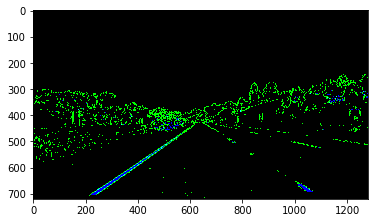

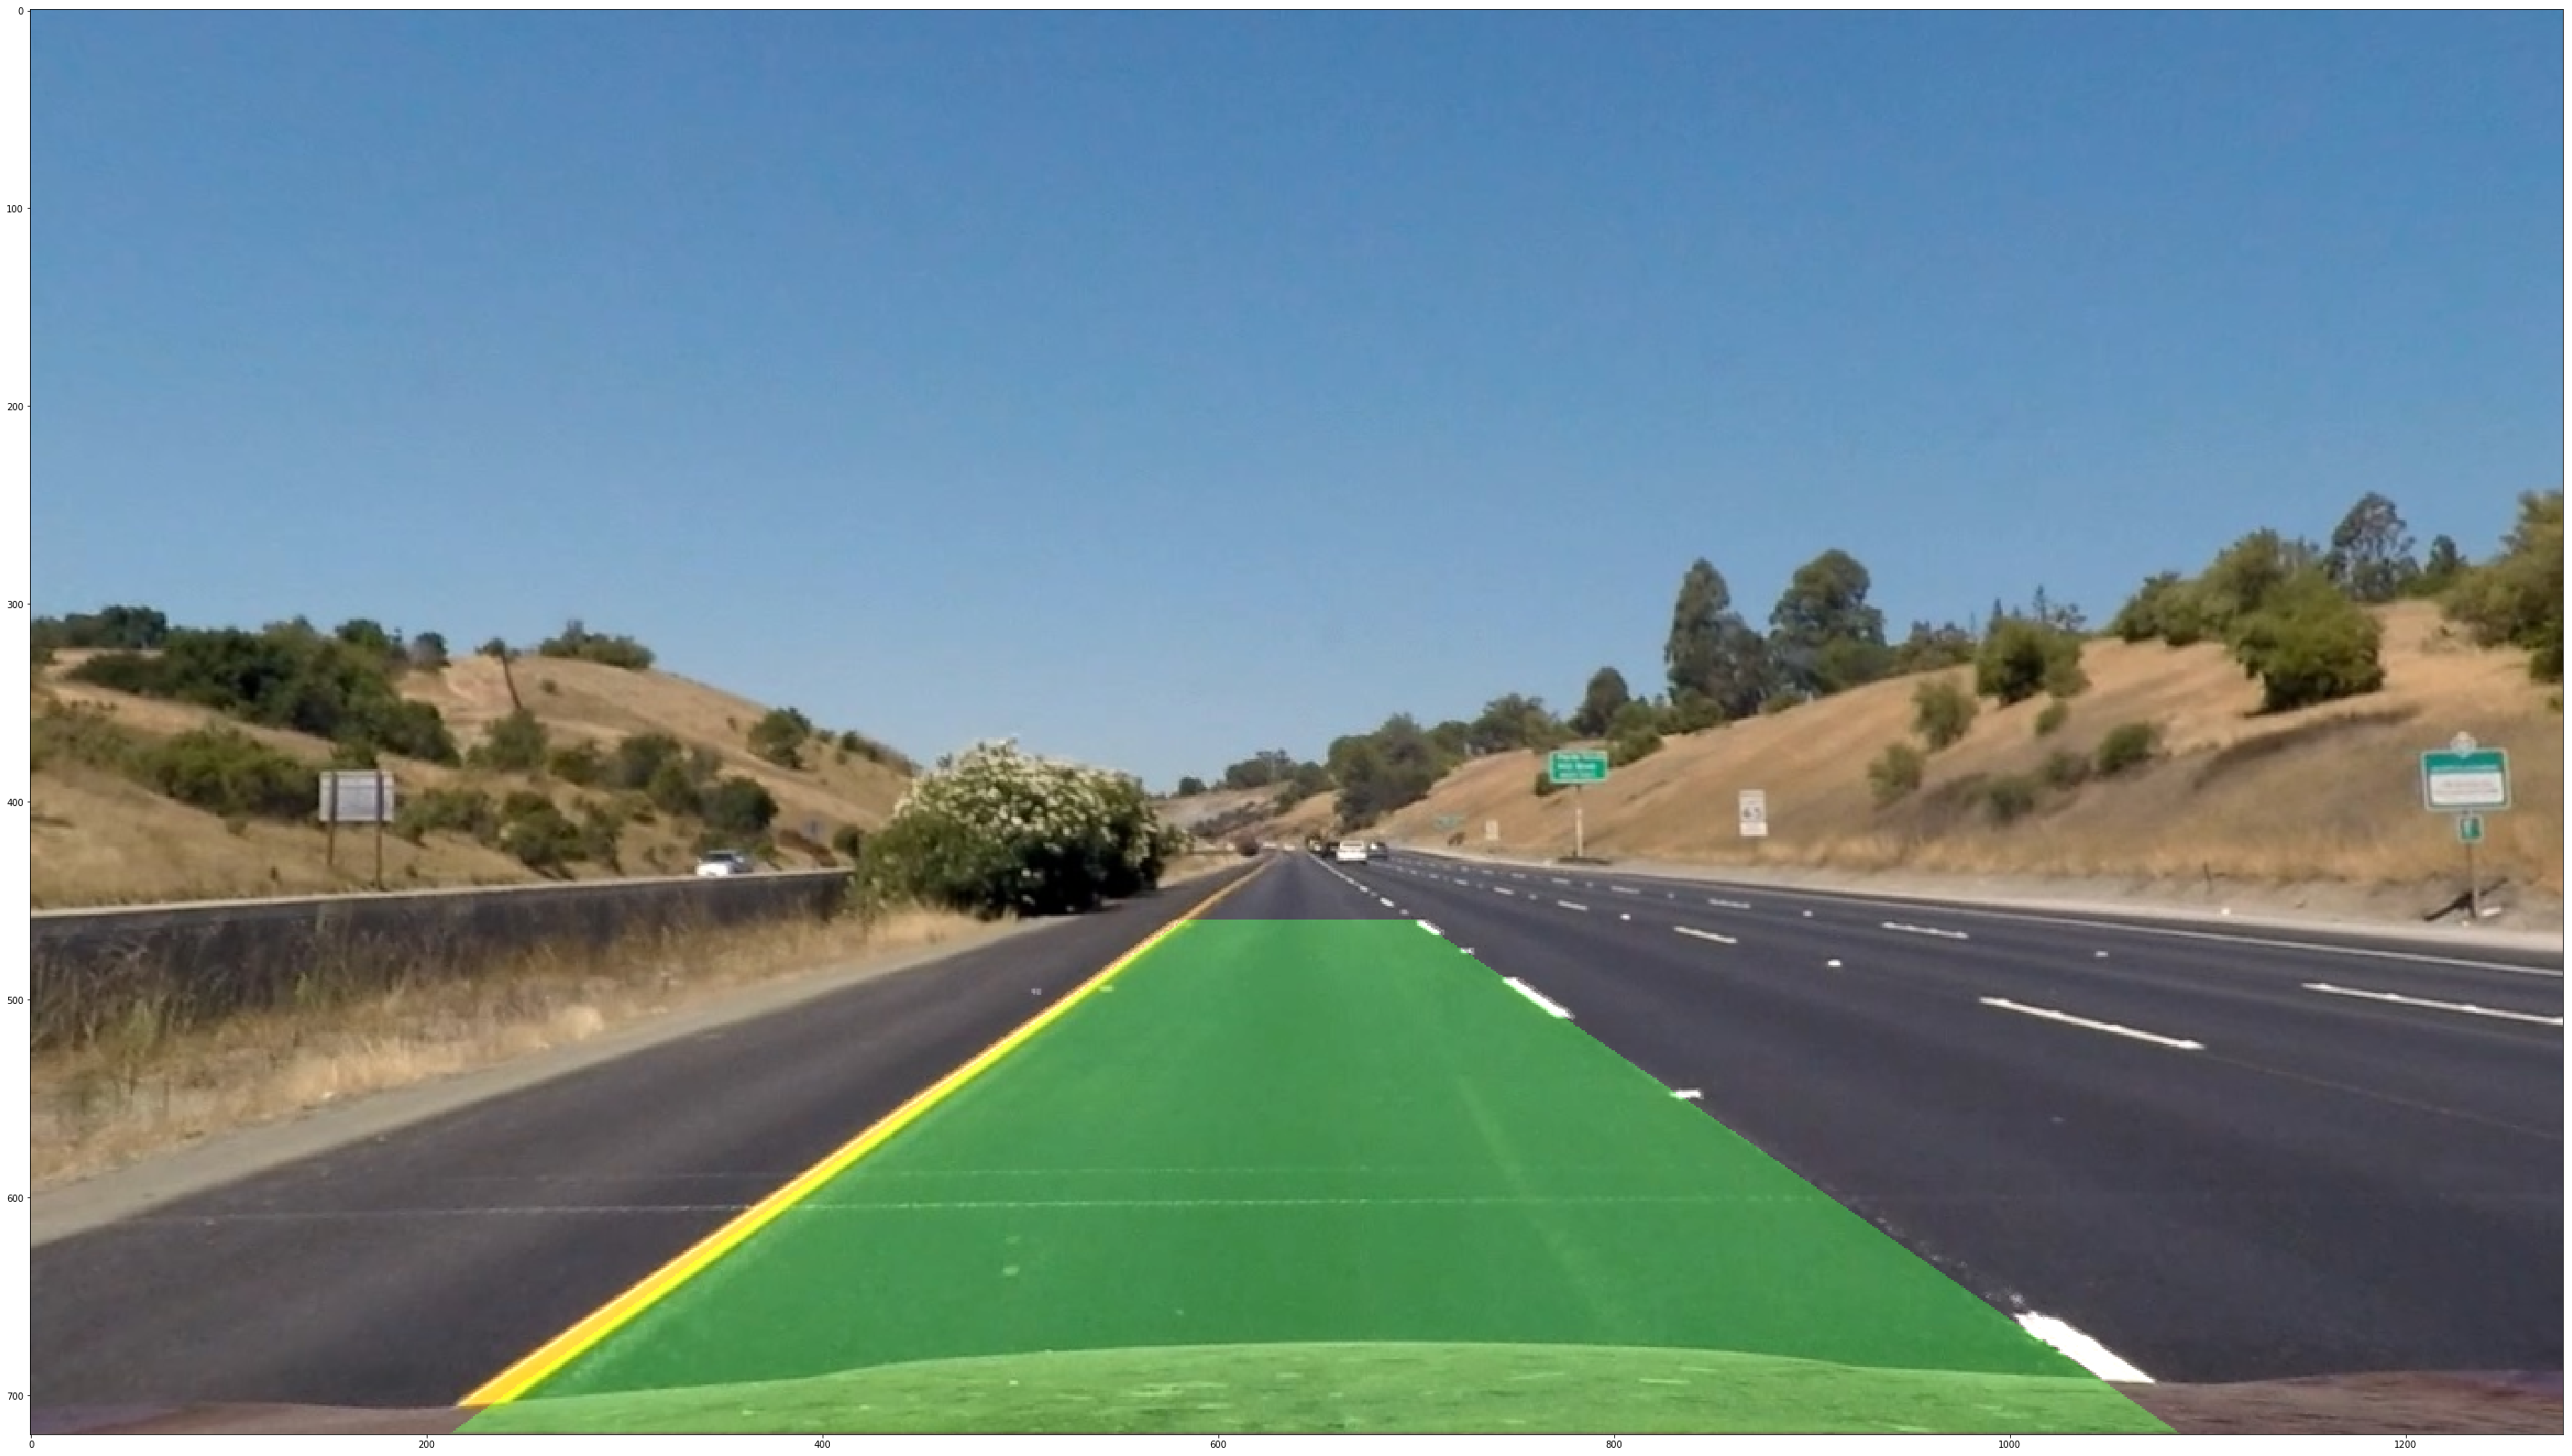

In [10]:
def back_projection(binary_warped_top_view, left_fit, right_fit, inv_perspective_matrix):
    
    # Image
    img_shape = binary_warped_top_view.shape

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped_top_view).astype(np.uint8)
    color_warp = np.dstack((binary_warped_top_view, binary_warped_top_view, binary_warped_top_view))#np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (inv_perspective_matrix)
    return cv2.warpPerspective(color_warp, inv_perspective_matrix, (img_shape[1], img_shape[0])) 

    
############### TESTS ###############  
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary = apply_threshold(undistorted_img)
img_with_roi, transformed_top_down_img, inv_perspective_matrix = top_down_view(binary)

binary_top_down = cv2.cvtColor(transformed_top_down_img, cv2.COLOR_BGR2GRAY)
# Find lane pixels first (coarse)
leftx, lefty, rightx, righty, out_img = find_lane_coarse(binary_top_down)
# Fit a second order polynomial to lane pixels
left_fit  = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Find lane pixels (fine)
found, leftx, lefty, rightx, righty, fine_search_img = find_lane_fine(binary_top_down, left_fit, right_fit)


# Back Projection
result_img = back_projection(binary_top_down, left_fit, right_fit, inv_perspective_matrix)

###### Debug save
cv2.imwrite('output_images/back_projected.png', result_img)

# Combine the result with the original image
img = cv2.addWeighted(undistorted_img, 1, result_img, 0.3, 0)
plt.figure(figsize=(50,50))
plt.imshow(img)

## 7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

(1280, 720)


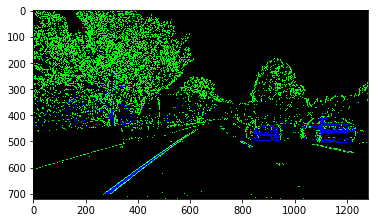

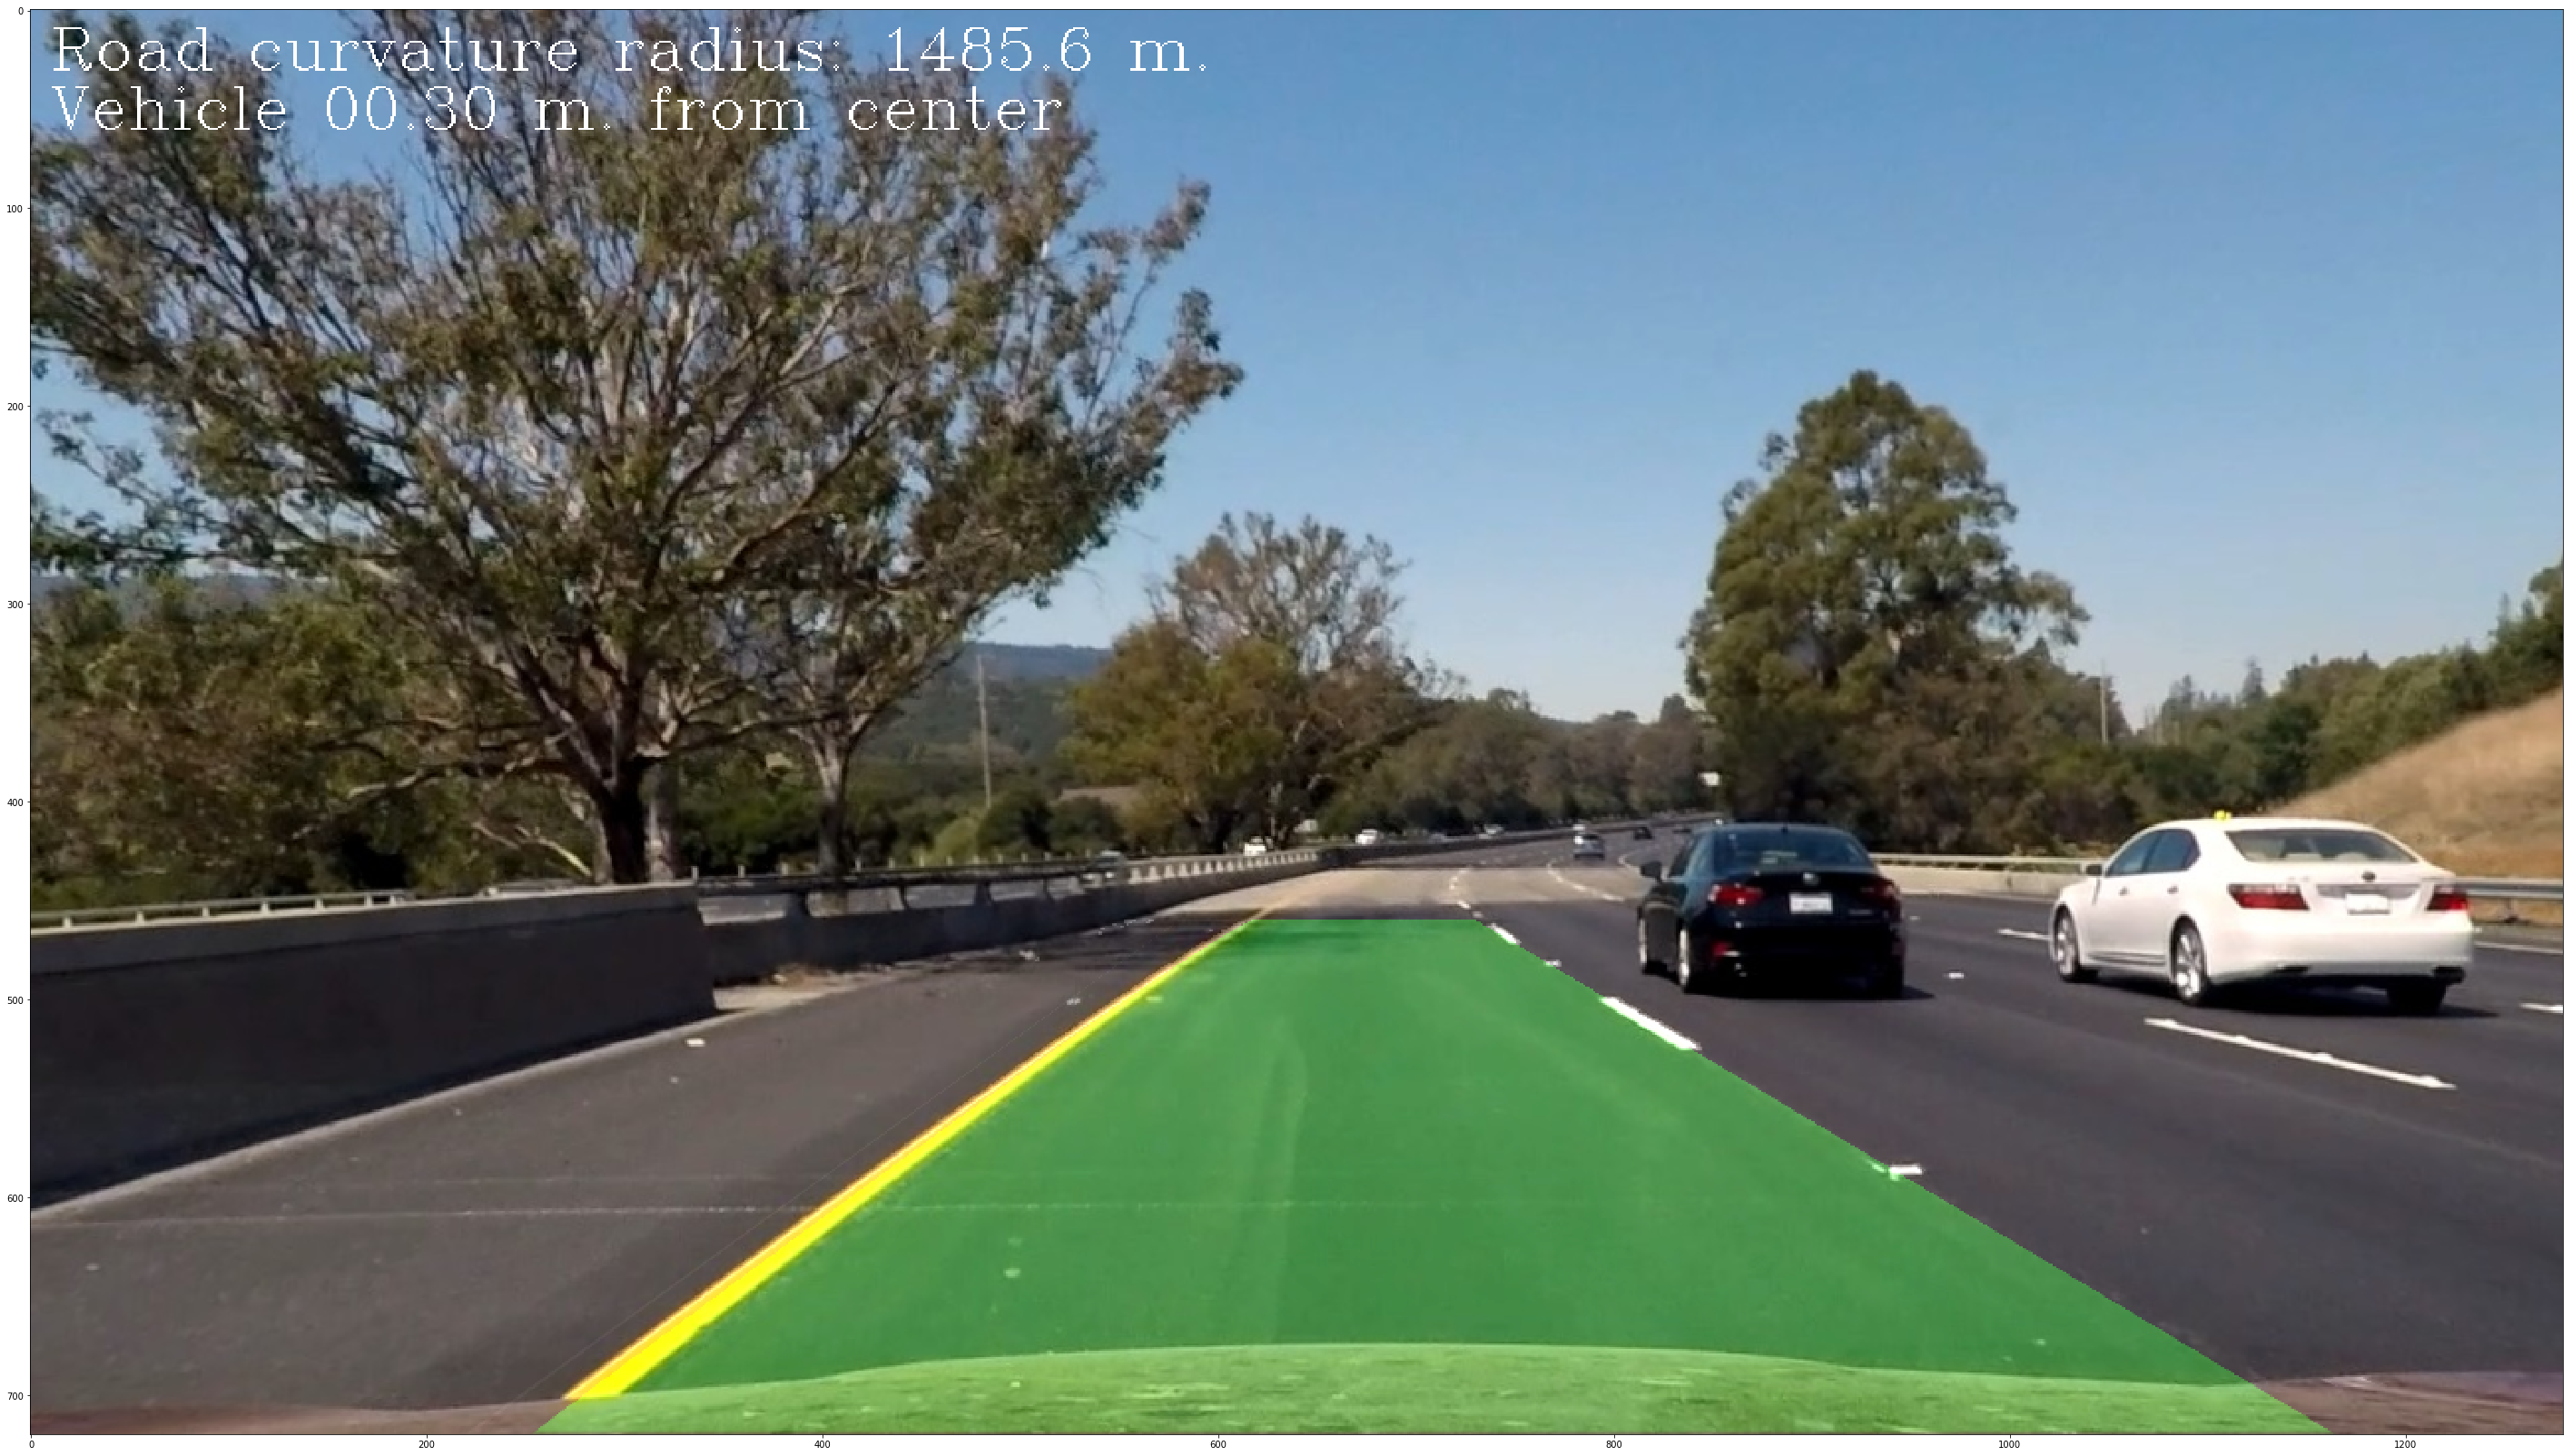

In [11]:
############### TESTS ###############  
image = cv2.imread('test_images/test6.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary = apply_threshold(undistorted_img)
img_with_roi, transformed_top_down_img, inv_perspective_matrix = top_down_view(binary)

binary_top_down = cv2.cvtColor(transformed_top_down_img, cv2.COLOR_BGR2GRAY)
# Find lane pixels first (coarse)
leftx, lefty, rightx, righty, out_img = find_lane_coarse(binary_top_down)
# Fit a second order polynomial to lane pixels
left_fit  = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Find lane pixels (fine)
found, leftx, lefty, rightx, righty, fine_search_img = find_lane_fine(binary_top_down, left_fit, right_fit)


# Back Projection
result_img = back_projection(binary_top_down, left_fit, right_fit, inv_perspective_matrix)
# Combine the result with the original image
img = cv2.addWeighted(undistorted_img, 1, result_img, 0.3, 0)


# Compute radius of curvature of the road and vehicle position relative to lane
radius = get_curvature(leftFit_m, rightFit_m, binary_top_down.shape[0]*ym_per_pix)
offset = get_offset_from_center(left_fit, right_fit, binary_top_down.shape[1]/2, binary_top_down.shape[0])
# Add measurements to the result image
# Curvature
txt = "Road curvature radius: %05.1f m." % (radius)
cv2.putText(img, txt, (10,30), cv2.FONT_HERSHEY_COMPLEX, 1, [255,255,255], 1) 
# Offset from Center
txt = "Vehicle %05.2f m. from center" % (np.fabs(offset)*xm_per_pix)
cv2.putText(img, txt, (10,60), cv2.FONT_HERSHEY_COMPLEX, 1, [255,255,255], 1)

plt.figure(figsize=(50,50))
plt.imshow(img)

## 8. Whole Lane detection processing pipeline

In [12]:
class LanesDetector:
    
    def __init__(self):
        self.coarse_search_enabled = True
        self.left_fit = np.array([0, 0, 0])
        self.right_fit = np.array([0, 0, 0])
        self.load_camera_params("camera_cal/camera_calib_pickle.p")

    def load_camera_params(self, params_file_path):
        '''
        Loads gloabl camera parameters athered during cam calibration etc. Search for "CAMERA_PICKLE" tag.
        '''
        cam_pickle = pickle.load(open(params_file_path, "rb") )
        self.cam_mtx = cam_pickle["cam_mtx"]
        self.dist_coeffs = cam_pickle["dist_coeffs"]
        self.inv_perspective_matrix = cam_pickle["inv_perspective_matrix"]
        self.ym_per_pix = cam_pickle["ym_per_pix"] # Meters per pixel in y dimension
        self.xm_per_pix = cam_pickle["xm_per_pix"] # Meters per pixel in x dimension
        #print(cam_pickle)
    
    def process_img(self, image):
        undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
        binary = apply_threshold(undistorted_img, grad_thresh=(20,100), s_color_thresh=(200,255))
        img_with_roi, transformed_top_down_img, inv_perspective_matrix = top_down_view(binary)

        binary_top_down = cv2.cvtColor(transformed_top_down_img, cv2.COLOR_BGR2GRAY)

        if self.coarse_search_enabled:
            # Search for lane pixels lines first (coarse)
            leftx, lefty, rightx, righty, out_img = find_lane_coarse(binary_top_down)
            self.coarse_search_enabled = False
        else:
            # Find lane pixels (fine), Here we know where the lanes are on the image
            found_lane, leftx, lefty, rightx, righty, out_img = find_lane_fine(binary_top_down, self.left_fit, self.right_fit)
            if found_lane == False:
                self.coarse_search_enabled == True

        if self.coarse_search_enabled == False:
            # Fit a second order polynomial to lane pixels
            self.left_fit  = np.polyfit(lefty, leftx, 2)
            self.right_fit = np.polyfit(righty, rightx, 2)
            
            
            # Apply exponential smoothing
            alpha = 0.85
            self.left_fit  = self.left_fit * alpha + self.left_fit * (1 - alpha)
            self.right_fit = self.right_fit * alpha + self.right_fit * (1 - alpha)

            # Fit a second order polynomial to lane pixels after scaling to real world units (meters)
            left_fit_m  = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
            right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

            # Back Projection
            result_img = back_projection(binary_top_down, self.left_fit, self.right_fit, inv_perspective_matrix)
            # Combine the result with the original image
            img = cv2.addWeighted(undistorted_img, 1, result_img, 0.3, 0)

            # Compute radius of curvature of the road and vehicle position relative to lane
            radius = get_curvature(left_fit_m, rightFit_m, binary_top_down.shape[0]*ym_per_pix)
            offset = get_offset_from_center(self.left_fit, self.right_fit, binary_top_down.shape[1]/2, binary_top_down.shape[0])
            # Add measurements to the result image
            # Curvature
            txt = "Road curvature radius: %05.1f m." % (radius)
            cv2.putText(img, txt, (10,30), cv2.FONT_HERSHEY_COMPLEX, 1, [255,255,255], 1) 
            # Offset from Center
            txt = "Vehicle %05.2f m. from center" % (np.fabs(offset)*xm_per_pix)
            cv2.putText(img, txt, (10,70), cv2.FONT_HERSHEY_COMPLEX, 1, [255,255,255], 1)
        return img


lanes_detector = LanesDetector()       

## 9. Search for lanes in Project Video stream 

In [13]:
# Set inputs and outputs
input_video1 = VideoFileClip("project_video.mp4")
output_video_name1 = 'project_video_output.mp4'
input_video2 = VideoFileClip("challenge_video.mp4")
output_video_name2 = 'challenge_video_output.mp4'
input_video3 = VideoFileClip("harder_challenge_video.mp4")
output_video_name3 = 'harder_challenge_video_output.mp4'

lanes_detector = LanesDetector()
process_img  = lanes_detector.process_img


(1280, 720)
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 1/1261 [00:00<02:36,  8.06it/s]

(1280, 720)


  0%|          | 2/1261 [00:00<02:35,  8.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  0%|          | 4/1261 [00:00<02:21,  8.85it/s]

(1280, 720)


  0%|          | 6/1261 [00:00<02:13,  9.39it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  1%|          | 8/1261 [00:00<02:10,  9.62it/s]

(1280, 720)
(1280, 720)


  1%|          | 10/1261 [00:00<02:06,  9.88it/s]

(1280, 720)


  1%|          | 12/1261 [00:01<02:04, 10.04it/s]

(1280, 720)
(1280, 720)


  1%|          | 15/1261 [00:01<02:02, 10.17it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  1%|▏         | 17/1261 [00:01<02:12,  9.40it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  2%|▏         | 21/1261 [00:02<02:24,  8.59it/s]

(1280, 720)
(1280, 720)


  2%|▏         | 23/1261 [00:02<02:26,  8.44it/s]

(1280, 720)
(1280, 720)


  2%|▏         | 24/1261 [00:02<02:30,  8.22it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  2%|▏         | 28/1261 [00:02<02:09,  9.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  2%|▏         | 30/1261 [00:03<02:03,  9.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  3%|▎         | 34/1261 [00:03<02:03,  9.90it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 36/1261 [00:03<02:01, 10.12it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  3%|▎         | 38/1261 [00:03<01:57, 10.45it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  3%|▎         | 42/1261 [00:04<01:51, 10.90it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  3%|▎         | 44/1261 [00:04<01:52, 10.80it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  4%|▍         | 48/1261 [00:04<01:50, 10.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  4%|▍         | 50/1261 [00:04<01:51, 10.89it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  4%|▍         | 54/1261 [00:05<01:50, 10.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  4%|▍         | 56/1261 [00:05<01:49, 11.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  5%|▍         | 60/1261 [00:05<01:48, 11.07it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  5%|▍         | 62/1261 [00:05<01:50, 10.86it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  5%|▌         | 66/1261 [00:06<01:48, 11.05it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  5%|▌         | 68/1261 [00:06<01:49, 10.88it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  6%|▌         | 72/1261 [00:06<01:50, 10.79it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  6%|▌         | 74/1261 [00:07<01:52, 10.57it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  6%|▌         | 78/1261 [00:07<01:50, 10.67it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  6%|▋         | 80/1261 [00:07<01:49, 10.78it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  7%|▋         | 84/1261 [00:08<01:47, 10.92it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  7%|▋         | 86/1261 [00:08<01:46, 11.00it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  7%|▋         | 90/1261 [00:08<01:45, 11.09it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  7%|▋         | 92/1261 [00:08<01:48, 10.81it/s]

(1280, 720)
(1280, 720)


  7%|▋         | 94/1261 [00:08<01:58,  9.87it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  8%|▊         | 98/1261 [00:09<01:49, 10.61it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  8%|▊         | 100/1261 [00:09<01:49, 10.59it/s]

(1280, 720)
(1280, 720)


  8%|▊         | 102/1261 [00:09<01:52, 10.27it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  8%|▊         | 106/1261 [00:10<01:52, 10.29it/s]

(1280, 720)
(1280, 720)


  9%|▊         | 108/1261 [00:10<01:52, 10.21it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  9%|▊         | 110/1261 [00:10<01:50, 10.45it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  9%|▉         | 114/1261 [00:10<01:48, 10.56it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  9%|▉         | 116/1261 [00:11<01:47, 10.66it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 10%|▉         | 120/1261 [00:11<01:47, 10.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 10%|▉         | 122/1261 [00:11<01:46, 10.69it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 10%|▉         | 126/1261 [00:12<01:46, 10.63it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 10%|█         | 128/1261 [00:12<01:45, 10.71it/s]

(1280, 720)
(1280, 720)


 10%|█         | 130/1261 [00:12<01:52, 10.04it/s]

(1280, 720)
(1280, 720)


 10%|█         | 132/1261 [00:12<01:53,  9.96it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 11%|█         | 136/1261 [00:12<01:46, 10.57it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 11%|█         | 138/1261 [00:13<01:44, 10.75it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 11%|█▏        | 142/1261 [00:13<01:45, 10.65it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 11%|█▏        | 144/1261 [00:13<01:46, 10.53it/s]

(1280, 720)
(1280, 720)


 12%|█▏        | 146/1261 [00:13<01:51,  9.99it/s]

(1280, 720)
(1280, 720)


 12%|█▏        | 148/1261 [00:14<01:54,  9.75it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 12%|█▏        | 152/1261 [00:14<01:53,  9.78it/s]

(1280, 720)
(1280, 720)


 12%|█▏        | 153/1261 [00:14<02:07,  8.67it/s]

(1280, 720)
(1280, 720)


 12%|█▏        | 155/1261 [00:14<02:01,  9.11it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 13%|█▎        | 159/1261 [00:15<01:53,  9.70it/s]

(1280, 720)
(1280, 720)


 13%|█▎        | 160/1261 [00:15<02:02,  8.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 13%|█▎        | 164/1261 [00:15<01:51,  9.86it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 13%|█▎        | 166/1261 [00:15<01:48, 10.13it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 13%|█▎        | 170/1261 [00:16<01:42, 10.67it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 14%|█▎        | 172/1261 [00:16<01:40, 10.82it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 14%|█▍        | 176/1261 [00:16<01:39, 10.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 14%|█▍        | 178/1261 [00:17<01:39, 10.91it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 14%|█▍        | 182/1261 [00:17<01:38, 10.99it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 15%|█▍        | 184/1261 [00:17<01:37, 11.08it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 15%|█▍        | 188/1261 [00:17<01:35, 11.20it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 15%|█▌        | 190/1261 [00:18<01:34, 11.29it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 15%|█▌        | 194/1261 [00:18<01:34, 11.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 16%|█▌        | 196/1261 [00:18<01:34, 11.25it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 16%|█▌        | 200/1261 [00:19<01:35, 11.15it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 16%|█▌        | 202/1261 [00:19<01:35, 11.07it/s]

(1280, 720)
(1280, 720)


 16%|█▌        | 204/1261 [00:19<01:45,  9.97it/s]

(1280, 720)
(1280, 720)


 16%|█▋        | 207/1261 [00:19<01:55,  9.10it/s]

(1280, 720)
(1280, 720)


 17%|█▋        | 209/1261 [00:20<01:59,  8.80it/s]

(1280, 720)
(1280, 720)


 17%|█▋        | 210/1261 [00:20<01:56,  9.01it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 17%|█▋        | 214/1261 [00:20<01:45,  9.90it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 17%|█▋        | 216/1261 [00:20<01:42, 10.22it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 17%|█▋        | 220/1261 [00:21<01:38, 10.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 18%|█▊        | 222/1261 [00:21<01:44,  9.90it/s]

(1280, 720)
(1280, 720)


 18%|█▊        | 224/1261 [00:21<01:49,  9.48it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 18%|█▊        | 227/1261 [00:21<01:48,  9.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 18%|█▊        | 231/1261 [00:22<01:41, 10.17it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 18%|█▊        | 233/1261 [00:22<01:41, 10.15it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 19%|█▉        | 237/1261 [00:22<01:36, 10.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 19%|█▉        | 239/1261 [00:22<01:35, 10.70it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 19%|█▉        | 243/1261 [00:23<01:36, 10.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 19%|█▉        | 245/1261 [00:23<01:36, 10.47it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 20%|█▉        | 249/1261 [00:23<01:35, 10.57it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 20%|█▉        | 251/1261 [00:24<01:33, 10.80it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 20%|██        | 255/1261 [00:24<01:31, 10.95it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 20%|██        | 257/1261 [00:24<01:33, 10.77it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 21%|██        | 261/1261 [00:24<01:31, 10.87it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 21%|██        | 263/1261 [00:25<01:30, 11.07it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 21%|██        | 267/1261 [00:25<01:31, 10.85it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 21%|██▏       | 269/1261 [00:25<01:31, 10.79it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 22%|██▏       | 273/1261 [00:26<01:30, 10.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 22%|██▏       | 275/1261 [00:26<01:28, 11.08it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 22%|██▏       | 279/1261 [00:26<01:28, 11.11it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 22%|██▏       | 281/1261 [00:26<01:28, 11.02it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 23%|██▎       | 285/1261 [00:27<01:27, 11.19it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 23%|██▎       | 287/1261 [00:27<01:26, 11.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 23%|██▎       | 291/1261 [00:27<01:27, 11.06it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 23%|██▎       | 293/1261 [00:27<01:29, 10.84it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 24%|██▎       | 297/1261 [00:28<01:27, 11.06it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 24%|██▎       | 299/1261 [00:28<01:27, 10.99it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 24%|██▍       | 303/1261 [00:28<01:26, 11.05it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 24%|██▍       | 305/1261 [00:28<01:26, 11.11it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 25%|██▍       | 309/1261 [00:29<01:24, 11.23it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 25%|██▍       | 311/1261 [00:29<01:25, 11.12it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 25%|██▍       | 315/1261 [00:29<01:24, 11.13it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 25%|██▌       | 317/1261 [00:30<01:24, 11.19it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 25%|██▌       | 321/1261 [00:30<01:23, 11.20it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 26%|██▌       | 323/1261 [00:30<01:24, 11.11it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 26%|██▌       | 327/1261 [00:30<01:27, 10.68it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 26%|██▌       | 329/1261 [00:31<01:27, 10.65it/s]

(1280, 720)
(1280, 720)


 26%|██▌       | 331/1261 [00:31<01:29, 10.38it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 27%|██▋       | 335/1261 [00:31<01:27, 10.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 27%|██▋       | 337/1261 [00:31<01:26, 10.73it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 27%|██▋       | 341/1261 [00:32<01:23, 10.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 27%|██▋       | 343/1261 [00:32<01:23, 11.00it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 28%|██▊       | 347/1261 [00:32<01:21, 11.15it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 28%|██▊       | 349/1261 [00:32<01:21, 11.15it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 28%|██▊       | 353/1261 [00:33<01:26, 10.44it/s]

(1280, 720)
(1280, 720)


 28%|██▊       | 355/1261 [00:33<01:26, 10.50it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 28%|██▊       | 357/1261 [00:33<01:24, 10.64it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 29%|██▊       | 361/1261 [00:34<01:24, 10.64it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 29%|██▉       | 363/1261 [00:34<01:25, 10.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 29%|██▉       | 367/1261 [00:34<01:24, 10.60it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 29%|██▉       | 369/1261 [00:34<01:22, 10.77it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 30%|██▉       | 373/1261 [00:35<01:21, 10.90it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 30%|██▉       | 375/1261 [00:35<01:21, 10.81it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 30%|███       | 379/1261 [00:35<01:23, 10.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 30%|███       | 381/1261 [00:36<01:23, 10.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 31%|███       | 385/1261 [00:36<01:21, 10.70it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 31%|███       | 387/1261 [00:36<01:20, 10.81it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 31%|███       | 391/1261 [00:36<01:21, 10.71it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 31%|███       | 393/1261 [00:37<01:19, 10.93it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 31%|███▏      | 397/1261 [00:37<01:18, 11.06it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 32%|███▏      | 399/1261 [00:37<01:17, 11.07it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 32%|███▏      | 403/1261 [00:38<01:17, 11.11it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 32%|███▏      | 405/1261 [00:38<01:16, 11.21it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 32%|███▏      | 409/1261 [00:38<01:15, 11.29it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 33%|███▎      | 411/1261 [00:38<01:15, 11.23it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 33%|███▎      | 415/1261 [00:39<01:16, 11.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 33%|███▎      | 417/1261 [00:39<01:16, 11.09it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 33%|███▎      | 421/1261 [00:39<01:16, 10.98it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 34%|███▎      | 423/1261 [00:39<01:17, 10.88it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 34%|███▍      | 427/1261 [00:40<01:15, 10.99it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 34%|███▍      | 429/1261 [00:40<01:14, 11.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 34%|███▍      | 433/1261 [00:40<01:16, 10.88it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 34%|███▍      | 435/1261 [00:40<01:16, 10.77it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 35%|███▍      | 439/1261 [00:41<01:16, 10.69it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 35%|███▍      | 441/1261 [00:41<01:17, 10.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 35%|███▌      | 445/1261 [00:41<01:14, 10.92it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 35%|███▌      | 447/1261 [00:42<01:14, 10.98it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 36%|███▌      | 451/1261 [00:42<01:12, 11.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 36%|███▌      | 453/1261 [00:42<01:12, 11.17it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 36%|███▌      | 457/1261 [00:42<01:11, 11.22it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 36%|███▋      | 459/1261 [00:43<01:13, 10.98it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 37%|███▋      | 463/1261 [00:43<01:13, 10.86it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 37%|███▋      | 465/1261 [00:43<01:12, 10.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 37%|███▋      | 469/1261 [00:44<01:11, 11.11it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 37%|███▋      | 471/1261 [00:44<01:11, 11.08it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 38%|███▊      | 475/1261 [00:44<01:10, 11.22it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 38%|███▊      | 477/1261 [00:44<01:11, 11.01it/s]

(1280, 720)
(1280, 720)


 38%|███▊      | 479/1261 [00:44<01:14, 10.56it/s]

(1280, 720)
(1280, 720)


 38%|███▊      | 481/1261 [00:45<01:15, 10.39it/s]

(1280, 720)
(1280, 720)


 38%|███▊      | 484/1261 [00:45<01:20,  9.62it/s]

(1280, 720)
(1280, 720)


 39%|███▊      | 486/1261 [00:45<01:23,  9.30it/s]

(1280, 720)
(1280, 720)


 39%|███▊      | 488/1261 [00:45<01:24,  9.10it/s]

(1280, 720)
(1280, 720)


 39%|███▉      | 490/1261 [00:46<01:22,  9.40it/s]

(1280, 720)
(1280, 720)


 39%|███▉      | 491/1261 [00:46<01:25,  8.98it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 39%|███▉      | 495/1261 [00:46<01:18,  9.76it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 39%|███▉      | 498/1261 [00:46<01:21,  9.34it/s]

(1280, 720)
(1280, 720)


 40%|███▉      | 499/1261 [00:47<01:23,  9.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 40%|███▉      | 503/1261 [00:47<01:20,  9.39it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 40%|████      | 505/1261 [00:47<01:17,  9.80it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 40%|████      | 509/1261 [00:48<01:18,  9.57it/s]

(1280, 720)
(1280, 720)


 40%|████      | 510/1261 [00:48<01:17,  9.67it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 41%|████      | 514/1261 [00:48<01:12, 10.29it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 41%|████      | 516/1261 [00:48<01:11, 10.47it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 41%|████      | 520/1261 [00:49<01:09, 10.63it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 41%|████▏     | 522/1261 [00:49<01:09, 10.61it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 42%|████▏     | 526/1261 [00:49<01:10, 10.38it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 42%|████▏     | 528/1261 [00:49<01:09, 10.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 42%|████▏     | 532/1261 [00:50<01:06, 10.89it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 42%|████▏     | 534/1261 [00:50<01:06, 10.95it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 43%|████▎     | 538/1261 [00:50<01:08, 10.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 43%|████▎     | 540/1261 [00:50<01:06, 10.82it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 43%|████▎     | 544/1261 [00:51<01:06, 10.73it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 43%|████▎     | 546/1261 [00:51<01:05, 10.92it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 44%|████▎     | 550/1261 [00:51<01:05, 10.77it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 44%|████▍     | 552/1261 [00:52<01:05, 10.80it/s]

(1280, 720)
(1280, 720)


 44%|████▍     | 556/1261 [00:52<01:05, 10.75it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 44%|████▍     | 558/1261 [00:52<01:03, 10.99it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 45%|████▍     | 562/1261 [00:52<01:01, 11.40it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 45%|████▍     | 564/1261 [00:53<01:00, 11.46it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 45%|████▌     | 568/1261 [00:53<00:59, 11.60it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 45%|████▌     | 570/1261 [00:53<00:58, 11.73it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 46%|████▌     | 574/1261 [00:53<00:56, 12.18it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 46%|████▌     | 576/1261 [00:54<00:56, 12.09it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 46%|████▌     | 580/1261 [00:54<00:55, 12.33it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 46%|████▌     | 582/1261 [00:54<00:55, 12.27it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 46%|████▋     | 584/1261 [00:54<00:54, 12.39it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 47%|████▋     | 588/1261 [00:55<00:58, 11.48it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 47%|████▋     | 592/1261 [00:55<00:55, 12.02it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 47%|████▋     | 594/1261 [00:55<00:54, 12.21it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 47%|████▋     | 598/1261 [00:55<00:53, 12.37it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 48%|████▊     | 600/1261 [00:56<00:54, 12.14it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 48%|████▊     | 604/1261 [00:56<00:52, 12.42it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 48%|████▊     | 606/1261 [00:56<00:53, 12.26it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 48%|████▊     | 608/1261 [00:56<00:54, 11.96it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 49%|████▊     | 612/1261 [00:57<00:57, 11.31it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 49%|████▊     | 614/1261 [00:57<00:59, 10.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 49%|████▉     | 618/1261 [00:57<01:00, 10.69it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 49%|████▉     | 620/1261 [00:57<01:01, 10.40it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 49%|████▉     | 624/1261 [00:58<01:00, 10.46it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 50%|████▉     | 626/1261 [00:58<00:59, 10.66it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 50%|████▉     | 630/1261 [00:58<00:58, 10.88it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 50%|█████     | 632/1261 [00:59<00:57, 10.91it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 50%|█████     | 636/1261 [00:59<00:57, 10.84it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 51%|█████     | 638/1261 [00:59<00:58, 10.69it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 51%|█████     | 642/1261 [00:59<00:58, 10.65it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 51%|█████     | 644/1261 [01:00<00:57, 10.64it/s]

(1280, 720)
(1280, 720)


 51%|█████     | 646/1261 [01:00<01:01, 10.07it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 52%|█████▏    | 650/1261 [01:00<00:58, 10.50it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 52%|█████▏    | 652/1261 [01:00<00:57, 10.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 52%|█████▏    | 656/1261 [01:01<01:00,  9.98it/s]

(1280, 720)
(1280, 720)


 52%|█████▏    | 658/1261 [01:01<01:03,  9.44it/s]

(1280, 720)
(1280, 720)


 52%|█████▏    | 660/1261 [01:01<01:10,  8.54it/s]

(1280, 720)
(1280, 720)


 52%|█████▏    | 662/1261 [01:02<01:06,  9.00it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 53%|█████▎    | 665/1261 [01:02<01:05,  9.17it/s]

(1280, 720)
(1280, 720)


 53%|█████▎    | 667/1261 [01:02<01:02,  9.55it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 53%|█████▎    | 670/1261 [01:02<00:59,  9.91it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 53%|█████▎    | 673/1261 [01:03<00:57, 10.14it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 54%|█████▎    | 675/1261 [01:03<00:57, 10.24it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 54%|█████▍    | 679/1261 [01:03<00:55, 10.48it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 54%|█████▍    | 681/1261 [01:03<00:54, 10.65it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 54%|█████▍    | 685/1261 [01:04<00:54, 10.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 54%|█████▍    | 687/1261 [01:04<00:57,  9.96it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 55%|█████▍    | 691/1261 [01:04<00:56, 10.00it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 55%|█████▍    | 693/1261 [01:05<00:55, 10.26it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 55%|█████▌    | 697/1261 [01:05<00:52, 10.68it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 55%|█████▌    | 699/1261 [01:05<00:52, 10.71it/s]

(1280, 720)
(1280, 720)


 56%|█████▌    | 701/1261 [01:05<00:54, 10.28it/s]

(1280, 720)
(1280, 720)


 56%|█████▌    | 703/1261 [01:06<00:54, 10.17it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 56%|█████▌    | 707/1261 [01:06<00:52, 10.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 56%|█████▌    | 709/1261 [01:06<00:51, 10.64it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 57%|█████▋    | 713/1261 [01:06<00:50, 10.95it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 57%|█████▋    | 715/1261 [01:07<00:50, 10.83it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 57%|█████▋    | 719/1261 [01:07<00:52, 10.32it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 57%|█████▋    | 721/1261 [01:07<00:51, 10.39it/s]

(1280, 720)
(1280, 720)


 57%|█████▋    | 723/1261 [01:07<00:52, 10.17it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 58%|█████▊    | 727/1261 [01:08<00:52, 10.18it/s]

(1280, 720)
(1280, 720)


 58%|█████▊    | 729/1261 [01:08<00:51, 10.25it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 58%|█████▊    | 731/1261 [01:08<00:50, 10.42it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 58%|█████▊    | 735/1261 [01:09<00:49, 10.60it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 58%|█████▊    | 737/1261 [01:09<00:49, 10.66it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 59%|█████▉    | 741/1261 [01:09<00:48, 10.69it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 59%|█████▉    | 743/1261 [01:09<00:48, 10.75it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 59%|█████▉    | 747/1261 [01:10<00:47, 10.81it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 59%|█████▉    | 749/1261 [01:10<00:46, 10.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 60%|█████▉    | 753/1261 [01:10<00:46, 11.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 60%|█████▉    | 755/1261 [01:10<00:45, 11.00it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 60%|██████    | 759/1261 [01:11<00:46, 10.73it/s]

(1280, 720)
(1280, 720)


 60%|██████    | 761/1261 [01:11<00:49, 10.19it/s]

(1280, 720)
(1280, 720)


 61%|██████    | 763/1261 [01:11<00:50,  9.86it/s]

(1280, 720)
(1280, 720)


 61%|██████    | 764/1261 [01:11<00:50,  9.87it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 61%|██████    | 767/1261 [01:12<00:52,  9.41it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 61%|██████    | 771/1261 [01:12<00:47, 10.36it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 61%|██████▏   | 773/1261 [01:12<00:45, 10.71it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 62%|██████▏   | 777/1261 [01:13<00:45, 10.57it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 62%|██████▏   | 779/1261 [01:13<00:46, 10.43it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 62%|██████▏   | 783/1261 [01:13<00:44, 10.69it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 62%|██████▏   | 785/1261 [01:13<00:43, 10.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 63%|██████▎   | 789/1261 [01:14<00:42, 11.06it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 63%|██████▎   | 791/1261 [01:14<00:42, 10.96it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 63%|██████▎   | 795/1261 [01:14<00:44, 10.44it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 63%|██████▎   | 797/1261 [01:14<00:46, 10.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 64%|██████▎   | 801/1261 [01:15<00:46,  9.83it/s]

(1280, 720)
(1280, 720)


 64%|██████▎   | 802/1261 [01:15<00:47,  9.64it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 64%|██████▍   | 806/1261 [01:15<00:46,  9.81it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 64%|██████▍   | 808/1261 [01:16<00:45, 10.01it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 64%|██████▍   | 812/1261 [01:16<00:42, 10.57it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 65%|██████▍   | 814/1261 [01:16<00:42, 10.49it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 65%|██████▍   | 818/1261 [01:16<00:41, 10.57it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 65%|██████▌   | 820/1261 [01:17<00:41, 10.56it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 65%|██████▌   | 824/1261 [01:17<00:40, 10.78it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▌   | 826/1261 [01:17<00:40, 10.86it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▌   | 830/1261 [01:18<00:38, 11.07it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▌   | 832/1261 [01:18<00:38, 11.03it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▋   | 836/1261 [01:18<00:38, 10.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▋   | 838/1261 [01:18<00:38, 10.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 67%|██████▋   | 842/1261 [01:19<00:37, 11.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 67%|██████▋   | 844/1261 [01:19<00:37, 11.01it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 67%|██████▋   | 848/1261 [01:19<00:37, 11.06it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 67%|██████▋   | 850/1261 [01:19<00:37, 11.09it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 68%|██████▊   | 854/1261 [01:20<00:36, 11.11it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 68%|██████▊   | 856/1261 [01:20<00:36, 11.17it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 68%|██████▊   | 860/1261 [01:20<00:35, 11.25it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 68%|██████▊   | 862/1261 [01:20<00:36, 10.93it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 69%|██████▊   | 866/1261 [01:21<00:37, 10.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 69%|██████▉   | 868/1261 [01:21<00:36, 10.74it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 69%|██████▉   | 872/1261 [01:21<00:35, 11.03it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 69%|██████▉   | 874/1261 [01:22<00:34, 11.07it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 70%|██████▉   | 878/1261 [01:22<00:34, 11.13it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 70%|██████▉   | 880/1261 [01:22<00:34, 11.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 70%|███████   | 884/1261 [01:22<00:33, 11.24it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 70%|███████   | 886/1261 [01:23<00:33, 11.18it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 71%|███████   | 890/1261 [01:23<00:33, 11.15it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 71%|███████   | 892/1261 [01:23<00:33, 10.85it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 71%|███████   | 896/1261 [01:24<00:34, 10.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 71%|███████   | 898/1261 [01:24<00:33, 10.70it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 72%|███████▏  | 902/1261 [01:24<00:32, 10.90it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 72%|███████▏  | 904/1261 [01:24<00:32, 10.99it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 72%|███████▏  | 908/1261 [01:25<00:31, 11.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 72%|███████▏  | 910/1261 [01:25<00:32, 10.77it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 72%|███████▏  | 914/1261 [01:25<00:32, 10.77it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 73%|███████▎  | 916/1261 [01:25<00:31, 10.87it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 73%|███████▎  | 920/1261 [01:26<00:30, 11.02it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 73%|███████▎  | 922/1261 [01:26<00:30, 10.95it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 73%|███████▎  | 926/1261 [01:26<00:32, 10.41it/s]

(1280, 720)
(1280, 720)


 74%|███████▎  | 928/1261 [01:27<00:32, 10.22it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 74%|███████▍  | 930/1261 [01:27<00:32, 10.20it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 74%|███████▍  | 934/1261 [01:27<00:30, 10.56it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 74%|███████▍  | 936/1261 [01:27<00:30, 10.73it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 75%|███████▍  | 940/1261 [01:28<00:29, 10.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 75%|███████▍  | 942/1261 [01:28<00:29, 10.84it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 75%|███████▌  | 946/1261 [01:28<00:28, 10.90it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 75%|███████▌  | 948/1261 [01:28<00:28, 10.83it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 75%|███████▌  | 952/1261 [01:29<00:27, 11.11it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 76%|███████▌  | 954/1261 [01:29<00:27, 11.02it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 76%|███████▌  | 958/1261 [01:29<00:27, 10.90it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 76%|███████▌  | 960/1261 [01:29<00:27, 10.91it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 76%|███████▋  | 964/1261 [01:30<00:26, 11.12it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 77%|███████▋  | 966/1261 [01:30<00:26, 11.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 77%|███████▋  | 970/1261 [01:30<00:26, 11.05it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 77%|███████▋  | 972/1261 [01:31<00:25, 11.12it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 77%|███████▋  | 976/1261 [01:31<00:26, 10.88it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 78%|███████▊  | 978/1261 [01:31<00:25, 10.96it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 78%|███████▊  | 982/1261 [01:31<00:25, 10.84it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 78%|███████▊  | 986/1261 [01:32<00:24, 11.14it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 78%|███████▊  | 988/1261 [01:32<00:23, 11.43it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 79%|███████▊  | 992/1261 [01:32<00:22, 11.82it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 79%|███████▉  | 994/1261 [01:33<00:22, 11.82it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 79%|███████▉  | 998/1261 [01:33<00:22, 11.84it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 79%|███████▉  | 1000/1261 [01:33<00:21, 12.03it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 80%|███████▉  | 1004/1261 [01:33<00:21, 12.08it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 80%|███████▉  | 1006/1261 [01:34<00:20, 12.24it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 80%|████████  | 1010/1261 [01:34<00:20, 12.16it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 80%|████████  | 1012/1261 [01:34<00:20, 12.02it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 81%|████████  | 1016/1261 [01:34<00:20, 11.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 81%|████████  | 1018/1261 [01:35<00:20, 12.03it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 81%|████████  | 1020/1261 [01:35<00:19, 12.06it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 81%|████████  | 1024/1261 [01:35<00:20, 11.63it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 82%|████████▏ | 1028/1261 [01:35<00:19, 11.74it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 82%|████████▏ | 1030/1261 [01:36<00:19, 11.61it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 82%|████████▏ | 1032/1261 [01:36<00:19, 11.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 82%|████████▏ | 1036/1261 [01:36<00:20, 11.17it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 82%|████████▏ | 1038/1261 [01:36<00:20, 10.86it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 83%|████████▎ | 1042/1261 [01:37<00:21, 10.34it/s]

(1280, 720)
(1280, 720)


 83%|████████▎ | 1044/1261 [01:37<00:21,  9.92it/s]

(1280, 720)
(1280, 720)


 83%|████████▎ | 1046/1261 [01:37<00:22,  9.60it/s]

(1280, 720)
(1280, 720)


 83%|████████▎ | 1048/1261 [01:37<00:22,  9.62it/s]

(1280, 720)
(1280, 720)


 83%|████████▎ | 1049/1261 [01:37<00:21,  9.65it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 84%|████████▎ | 1053/1261 [01:38<00:20, 10.11it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 84%|████████▎ | 1055/1261 [01:38<00:19, 10.37it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 84%|████████▍ | 1059/1261 [01:38<00:19, 10.47it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 84%|████████▍ | 1061/1261 [01:39<00:19, 10.47it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 84%|████████▍ | 1065/1261 [01:39<00:18, 10.60it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 85%|████████▍ | 1067/1261 [01:39<00:18, 10.56it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 85%|████████▍ | 1071/1261 [01:39<00:17, 10.72it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 85%|████████▌ | 1073/1261 [01:40<00:17, 10.82it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 85%|████████▌ | 1077/1261 [01:40<00:16, 10.99it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 86%|████████▌ | 1079/1261 [01:40<00:16, 11.05it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 86%|████████▌ | 1083/1261 [01:41<00:16, 11.09it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 86%|████████▌ | 1085/1261 [01:41<00:16, 10.61it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 86%|████████▋ | 1089/1261 [01:41<00:16, 10.43it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 87%|████████▋ | 1091/1261 [01:41<00:16, 10.53it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 87%|████████▋ | 1095/1261 [01:42<00:15, 10.87it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 87%|████████▋ | 1097/1261 [01:42<00:15, 10.71it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 87%|████████▋ | 1101/1261 [01:42<00:14, 10.92it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 87%|████████▋ | 1103/1261 [01:42<00:14, 10.87it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 88%|████████▊ | 1107/1261 [01:43<00:14, 10.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 88%|████████▊ | 1109/1261 [01:43<00:13, 10.90it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 88%|████████▊ | 1113/1261 [01:43<00:13, 11.12it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 88%|████████▊ | 1115/1261 [01:44<00:13, 11.17it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 89%|████████▊ | 1119/1261 [01:44<00:12, 11.00it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 89%|████████▉ | 1121/1261 [01:44<00:12, 11.01it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 89%|████████▉ | 1125/1261 [01:44<00:12, 11.19it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 89%|████████▉ | 1127/1261 [01:45<00:11, 11.27it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 90%|████████▉ | 1131/1261 [01:45<00:11, 11.16it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 90%|████████▉ | 1133/1261 [01:45<00:11, 11.06it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 90%|█████████ | 1137/1261 [01:46<00:11, 11.08it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 90%|█████████ | 1139/1261 [01:46<00:10, 11.19it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 91%|█████████ | 1143/1261 [01:46<00:10, 11.18it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 91%|█████████ | 1145/1261 [01:46<00:10, 11.11it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 91%|█████████ | 1149/1261 [01:47<00:10, 10.96it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 91%|█████████▏| 1151/1261 [01:47<00:10, 10.89it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 92%|█████████▏| 1155/1261 [01:47<00:10, 10.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 92%|█████████▏| 1157/1261 [01:47<00:09, 10.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 92%|█████████▏| 1161/1261 [01:48<00:09, 10.81it/s]

(1280, 720)
(1280, 720)


 92%|█████████▏| 1163/1261 [01:48<00:10,  9.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 92%|█████████▏| 1166/1261 [01:48<00:10,  8.73it/s]

(1280, 720)
(1280, 720)


 93%|█████████▎| 1168/1261 [01:49<00:10,  9.21it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 93%|█████████▎| 1170/1261 [01:49<00:09,  9.66it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 93%|█████████▎| 1174/1261 [01:49<00:08, 10.03it/s]

(1280, 720)
(1280, 720)


 93%|█████████▎| 1176/1261 [01:49<00:08, 10.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 93%|█████████▎| 1178/1261 [01:49<00:07, 10.55it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 94%|█████████▎| 1182/1261 [01:50<00:07, 10.82it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 94%|█████████▍| 1184/1261 [01:50<00:07, 10.89it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 94%|█████████▍| 1188/1261 [01:50<00:06, 11.14it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 94%|█████████▍| 1190/1261 [01:51<00:06, 11.19it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 95%|█████████▍| 1194/1261 [01:51<00:06, 10.49it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 95%|█████████▍| 1196/1261 [01:51<00:06, 10.65it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 95%|█████████▌| 1200/1261 [01:51<00:05, 10.72it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 95%|█████████▌| 1202/1261 [01:52<00:05, 10.77it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 96%|█████████▌| 1206/1261 [01:52<00:05, 10.91it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 96%|█████████▌| 1208/1261 [01:52<00:04, 10.65it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 96%|█████████▌| 1212/1261 [01:53<00:04, 10.86it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 96%|█████████▋| 1214/1261 [01:53<00:04, 10.08it/s]

(1280, 720)
(1280, 720)


 96%|█████████▋| 1216/1261 [01:53<00:04,  9.88it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 97%|█████████▋| 1220/1261 [01:53<00:03, 10.56it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 97%|█████████▋| 1222/1261 [01:54<00:03, 10.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 97%|█████████▋| 1226/1261 [01:54<00:03, 10.68it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 97%|█████████▋| 1228/1261 [01:54<00:03, 10.00it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 98%|█████████▊| 1232/1261 [01:55<00:02, 10.60it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 98%|█████████▊| 1234/1261 [01:55<00:02, 10.71it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 98%|█████████▊| 1238/1261 [01:55<00:02, 10.95it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 98%|█████████▊| 1240/1261 [01:55<00:01, 10.98it/s]

(1280, 720)
(1280, 720)


 98%|█████████▊| 1242/1261 [01:55<00:01, 10.62it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 99%|█████████▉| 1246/1261 [01:56<00:01, 10.16it/s]

(1280, 720)
(1280, 720)


 99%|█████████▉| 1248/1261 [01:56<00:01,  9.75it/s]

(1280, 720)
(1280, 720)


 99%|█████████▉| 1250/1261 [01:56<00:01,  9.48it/s]

(1280, 720)
(1280, 720)


 99%|█████████▉| 1251/1261 [01:56<00:01,  9.32it/s]

(1280, 720)
(1280, 720)
(1280, 720)


100%|█████████▉| 1255/1261 [01:57<00:00,  9.86it/s]

(1280, 720)
(1280, 720)
(1280, 720)


100%|█████████▉| 1257/1261 [01:57<00:00,  9.97it/s]

(1280, 720)
(1280, 720)


100%|█████████▉| 1260/1261 [01:57<00:00, 10.70it/s]


(1280, 720)
(1280, 720)
[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 54s, sys: 4.15 s, total: 3min 58s
Wall time: 1min 58s


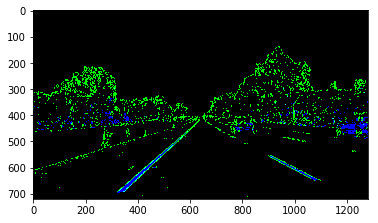

In [ ]:
# Process the input video
output_video1 = input_video1.fl_image(process_img)
%time output_video1.write_videofile(output_video_name1, audio=False)


In [14]:
# SHOW THE VIDEO 1
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_name1))

(1280, 720)
[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


  0%|          | 0/485 [00:00<?, ?it/s]

(1280, 720)


  0%|          | 2/485 [00:00<01:00,  7.95it/s]

(1280, 720)


  1%|          | 3/485 [00:00<00:59,  8.05it/s]

(1280, 720)


  1%|          | 4/485 [00:00<00:59,  8.06it/s]

(1280, 720)


  1%|          | 5/485 [00:00<00:57,  8.33it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  1%|▏         | 7/485 [00:00<00:53,  8.90it/s]

(1280, 720)


  2%|▏         | 9/485 [00:01<00:52,  9.02it/s]

(1280, 720)


  2%|▏         | 10/485 [00:01<00:52,  9.13it/s]

(1280, 720)


  2%|▏         | 11/485 [00:01<00:52,  8.99it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  3%|▎         | 13/485 [00:01<00:49,  9.47it/s]

(1280, 720)


  3%|▎         | 14/485 [00:01<00:49,  9.51it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 16/485 [00:01<00:47,  9.91it/s]

(1280, 720)


  4%|▎         | 18/485 [00:01<00:45, 10.18it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  4%|▍         | 20/485 [00:02<00:44, 10.44it/s]

(1280, 720)
(1280, 720)


  5%|▍         | 22/485 [00:02<00:43, 10.70it/s]

(1280, 720)


  5%|▍         | 24/485 [00:02<00:42, 10.84it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  5%|▌         | 26/485 [00:02<00:42, 10.91it/s]

(1280, 720)
(1280, 720)


  6%|▌         | 28/485 [00:02<00:41, 11.14it/s]

(1280, 720)


  6%|▌         | 30/485 [00:02<00:41, 10.89it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  7%|▋         | 32/485 [00:03<00:42, 10.65it/s]

(1280, 720)


  7%|▋         | 34/485 [00:03<00:42, 10.61it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  7%|▋         | 36/485 [00:03<00:42, 10.55it/s]

(1280, 720)


  8%|▊         | 38/485 [00:03<00:41, 10.84it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  8%|▊         | 40/485 [00:03<00:40, 10.89it/s]

(1280, 720)
(1280, 720)


  9%|▊         | 42/485 [00:04<00:40, 10.91it/s]

(1280, 720)


  9%|▉         | 44/485 [00:04<00:42, 10.46it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  9%|▉         | 46/485 [00:04<00:41, 10.53it/s]

(1280, 720)


 10%|▉         | 48/485 [00:04<00:41, 10.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 10%|█         | 50/485 [00:04<00:41, 10.48it/s]

(1280, 720)
(1280, 720)


 11%|█         | 52/485 [00:05<00:41, 10.40it/s]

(1280, 720)


 11%|█         | 54/485 [00:05<00:39, 10.82it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 12%|█▏        | 56/485 [00:05<00:39, 10.90it/s]

(1280, 720)
(1280, 720)


 12%|█▏        | 58/485 [00:05<00:38, 11.11it/s]

(1280, 720)


 12%|█▏        | 60/485 [00:05<00:37, 11.21it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 13%|█▎        | 64/485 [00:06<00:36, 11.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 14%|█▎        | 66/485 [00:06<00:35, 11.68it/s]

(1280, 720)
(1280, 720)


 14%|█▍        | 68/485 [00:06<00:35, 11.70it/s]

(1280, 720)


 14%|█▍        | 70/485 [00:06<00:34, 11.87it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 15%|█▍        | 72/485 [00:06<00:34, 11.84it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 15%|█▌        | 74/485 [00:06<00:36, 11.20it/s]

(1280, 720)
(1280, 720)


 16%|█▌        | 76/485 [00:07<00:36, 11.17it/s]

(1280, 720)


 16%|█▌        | 78/485 [00:07<00:36, 11.13it/s]

(1280, 720)
(1280, 720)


 16%|█▋        | 80/485 [00:07<00:35, 11.40it/s]

(1280, 720)


 17%|█▋        | 82/485 [00:07<00:34, 11.66it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 17%|█▋        | 84/485 [00:07<00:36, 11.09it/s]

(1280, 720)
(1280, 720)


 18%|█▊        | 86/485 [00:08<00:35, 11.30it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 18%|█▊        | 88/485 [00:08<00:35, 11.30it/s]

(1280, 720)


 19%|█▊        | 90/485 [00:08<00:34, 11.50it/s]

(1280, 720)
(1280, 720)


 19%|█▉        | 92/485 [00:08<00:33, 11.68it/s]

(1280, 720)


 19%|█▉        | 94/485 [00:08<00:33, 11.63it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 20%|█▉        | 96/485 [00:08<00:33, 11.69it/s]

(1280, 720)
(1280, 720)


 20%|██        | 98/485 [00:09<00:33, 11.69it/s]

(1280, 720)


 21%|██        | 100/485 [00:09<00:32, 11.92it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 21%|██        | 102/485 [00:09<00:31, 12.12it/s]

(1280, 720)
(1280, 720)


 21%|██▏       | 104/485 [00:09<00:31, 12.13it/s]

(1280, 720)


 22%|██▏       | 106/485 [00:09<00:31, 12.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 22%|██▏       | 108/485 [00:09<00:31, 12.01it/s]

(1280, 720)
(1280, 720)


 23%|██▎       | 110/485 [00:10<00:30, 12.22it/s]

(1280, 720)


 23%|██▎       | 112/485 [00:10<00:31, 12.02it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 24%|██▎       | 114/485 [00:10<00:30, 12.22it/s]

(1280, 720)
(1280, 720)


 24%|██▍       | 116/485 [00:10<00:29, 12.43it/s]

(1280, 720)


 24%|██▍       | 118/485 [00:10<00:29, 12.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 25%|██▍       | 120/485 [00:10<00:29, 12.55it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 25%|██▌       | 122/485 [00:11<00:30, 11.80it/s]

(1280, 720)
(1280, 720)


 26%|██▌       | 124/485 [00:11<00:31, 11.50it/s]

(1280, 720)


 26%|██▌       | 126/485 [00:11<00:31, 11.22it/s]

(1280, 720)
(1280, 720)


 26%|██▋       | 128/485 [00:11<00:30, 11.68it/s]

(1280, 720)


 27%|██▋       | 130/485 [00:11<00:29, 12.13it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 27%|██▋       | 132/485 [00:11<00:28, 12.27it/s]

(1280, 720)
(1280, 720)


 28%|██▊       | 134/485 [00:12<00:28, 12.31it/s]

(1280, 720)


 28%|██▊       | 136/485 [00:12<00:28, 12.40it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 28%|██▊       | 138/485 [00:12<00:27, 12.41it/s]

(1280, 720)
(1280, 720)


 29%|██▉       | 140/485 [00:12<00:27, 12.48it/s]

(1280, 720)


 29%|██▉       | 142/485 [00:12<00:27, 12.65it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 30%|██▉       | 144/485 [00:12<00:27, 12.34it/s]

(1280, 720)
(1280, 720)


 30%|███       | 146/485 [00:12<00:26, 12.59it/s]

(1280, 720)


 31%|███       | 148/485 [00:13<00:26, 12.57it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 31%|███       | 150/485 [00:13<00:26, 12.60it/s]

(1280, 720)
(1280, 720)


 31%|███▏      | 152/485 [00:13<00:26, 12.70it/s]

(1280, 720)


 32%|███▏      | 154/485 [00:13<00:26, 12.49it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 32%|███▏      | 156/485 [00:13<00:27, 12.12it/s]

(1280, 720)
(1280, 720)


 33%|███▎      | 158/485 [00:13<00:27, 12.06it/s]

(1280, 720)


 33%|███▎      | 160/485 [00:14<00:27, 12.01it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 33%|███▎      | 162/485 [00:14<00:27, 11.80it/s]

(1280, 720)
(1280, 720)


 34%|███▍      | 164/485 [00:14<00:27, 11.82it/s]

(1280, 720)


 34%|███▍      | 166/485 [00:14<00:27, 11.78it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 35%|███▍      | 168/485 [00:14<00:27, 11.68it/s]

(1280, 720)
(1280, 720)


 35%|███▌      | 170/485 [00:14<00:26, 11.69it/s]

(1280, 720)


 35%|███▌      | 172/485 [00:15<00:26, 11.69it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 36%|███▌      | 174/485 [00:15<00:26, 11.67it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 37%|███▋      | 178/485 [00:15<00:26, 11.61it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 37%|███▋      | 180/485 [00:15<00:26, 11.57it/s]

(1280, 720)
(1280, 720)


 38%|███▊      | 182/485 [00:16<00:26, 11.62it/s]

(1280, 720)


 38%|███▊      | 184/485 [00:16<00:25, 11.74it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 38%|███▊      | 186/485 [00:16<00:26, 11.45it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 39%|███▉      | 188/485 [00:16<00:26, 11.17it/s]

(1280, 720)
(1280, 720)


 39%|███▉      | 190/485 [00:16<00:26, 11.22it/s]

(1280, 720)


 40%|███▉      | 192/485 [00:16<00:26, 11.21it/s]

(1280, 720)
(1280, 720)


 40%|████      | 194/485 [00:17<00:25, 11.46it/s]

(1280, 720)


 40%|████      | 196/485 [00:17<00:24, 11.62it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 41%|████      | 198/485 [00:17<00:24, 11.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 41%|████      | 200/485 [00:17<00:25, 11.34it/s]

(1280, 720)
(1280, 720)


 42%|████▏     | 202/485 [00:17<00:24, 11.35it/s]

(1280, 720)


 42%|████▏     | 204/485 [00:17<00:24, 11.30it/s]

(1280, 720)
(1280, 720)


 42%|████▏     | 206/485 [00:18<00:24, 11.43it/s]

(1280, 720)


 43%|████▎     | 208/485 [00:18<00:24, 11.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 43%|████▎     | 210/485 [00:18<00:23, 11.73it/s]

(1280, 720)
(1280, 720)


 44%|████▎     | 212/485 [00:18<00:23, 11.83it/s]

(1280, 720)


 44%|████▍     | 214/485 [00:18<00:22, 12.00it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 45%|████▍     | 216/485 [00:18<00:22, 11.86it/s]

(1280, 720)
(1280, 720)


 45%|████▍     | 218/485 [00:19<00:22, 11.76it/s]

(1280, 720)


 45%|████▌     | 220/485 [00:19<00:22, 11.74it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 46%|████▌     | 222/485 [00:19<00:22, 11.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 46%|████▌     | 224/485 [00:19<00:23, 11.30it/s]

(1280, 720)
(1280, 720)


 47%|████▋     | 226/485 [00:19<00:22, 11.27it/s]

(1280, 720)


 47%|████▋     | 228/485 [00:20<00:22, 11.39it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 47%|████▋     | 230/485 [00:20<00:22, 11.40it/s]

(1280, 720)
(1280, 720)


 48%|████▊     | 232/485 [00:20<00:22, 11.21it/s]

(1280, 720)


 48%|████▊     | 234/485 [00:20<00:22, 11.20it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 49%|████▊     | 236/485 [00:20<00:23, 10.63it/s]

(1280, 720)
(1280, 720)


 49%|████▉     | 238/485 [00:20<00:23, 10.58it/s]

(1280, 720)


 49%|████▉     | 240/485 [00:21<00:22, 11.03it/s]

(1280, 720)
(1280, 720)


 50%|████▉     | 242/485 [00:21<00:21, 11.30it/s]

(1280, 720)


 50%|█████     | 244/485 [00:21<00:21, 11.40it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 51%|█████     | 246/485 [00:21<00:21, 10.87it/s]

(1280, 720)
(1280, 720)


 51%|█████     | 248/485 [00:21<00:22, 10.57it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 52%|█████▏    | 252/485 [00:22<00:22, 10.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 52%|█████▏    | 254/485 [00:22<00:21, 10.71it/s]

(1280, 720)
(1280, 720)


 53%|█████▎    | 256/485 [00:22<00:22, 10.11it/s]

(1280, 720)
(1280, 720)


 53%|█████▎    | 258/485 [00:22<00:22,  9.98it/s]

(1280, 720)
(1280, 720)


 54%|█████▎    | 260/485 [00:23<00:23,  9.60it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 54%|█████▍    | 263/485 [00:23<00:23,  9.56it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 55%|█████▌    | 267/485 [00:23<00:20, 10.62it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 56%|█████▌    | 271/485 [00:24<00:19, 11.07it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 56%|█████▋    | 273/485 [00:24<00:18, 11.32it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 57%|█████▋    | 277/485 [00:24<00:17, 11.75it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 58%|█████▊    | 279/485 [00:24<00:17, 11.84it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 58%|█████▊    | 283/485 [00:25<00:16, 12.06it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 59%|█████▉    | 285/485 [00:25<00:16, 11.85it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 59%|█████▉    | 287/485 [00:25<00:16, 11.77it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 60%|██████    | 291/485 [00:25<00:16, 11.77it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 61%|██████    | 295/485 [00:26<00:15, 11.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 61%|██████    | 297/485 [00:26<00:15, 12.00it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 62%|██████▏   | 301/485 [00:26<00:15, 11.96it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 62%|██████▏   | 303/485 [00:26<00:15, 12.01it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 63%|██████▎   | 307/485 [00:27<00:14, 12.14it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 64%|██████▎   | 309/485 [00:27<00:14, 12.02it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 65%|██████▍   | 313/485 [00:27<00:14, 12.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 65%|██████▍   | 315/485 [00:27<00:14, 12.05it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 65%|██████▌   | 317/485 [00:27<00:14, 11.72it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▌   | 321/485 [00:28<00:14, 11.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 67%|██████▋   | 323/485 [00:28<00:14, 11.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 67%|██████▋   | 327/485 [00:28<00:13, 11.55it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 68%|██████▊   | 331/485 [00:29<00:13, 11.72it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 69%|██████▊   | 333/485 [00:29<00:14, 10.85it/s]

(1280, 720)
(1280, 720)


 69%|██████▉   | 335/485 [00:29<00:14, 10.30it/s]

(1280, 720)
(1280, 720)


 69%|██████▉   | 337/485 [00:29<00:14,  9.91it/s]

(1280, 720)
(1280, 720)


 70%|██████▉   | 339/485 [00:29<00:14, 10.14it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 70%|███████   | 341/485 [00:30<00:13, 10.45it/s]

(1280, 720)
(1280, 720)


 71%|███████   | 344/485 [00:30<00:14,  9.65it/s]

(1280, 720)
(1280, 720)


 71%|███████▏  | 346/485 [00:30<00:13, 10.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 72%|███████▏  | 348/485 [00:30<00:13, 10.48it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 73%|███████▎  | 352/485 [00:31<00:12, 10.82it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 73%|███████▎  | 354/485 [00:31<00:11, 10.93it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 74%|███████▍  | 358/485 [00:31<00:12, 10.35it/s]

(1280, 720)
(1280, 720)


 74%|███████▍  | 360/485 [00:31<00:12, 10.37it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 75%|███████▍  | 362/485 [00:32<00:11, 10.46it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 75%|███████▌  | 364/485 [00:32<00:11, 10.56it/s]

(1280, 720)
(1280, 720)


KeyboardInterrupt: 

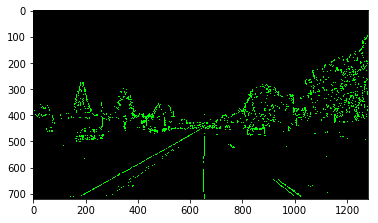

In [ ]:
output_video2 = input_video2.fl_image(process_img)
%time output_video2.write_videofile(output_video_name2, audio=False)


In [ ]:
# SHOW THE VIDEO 2
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_name2))

In [ ]:
output_video3 = input_video3.fl_image(process_img)
%time output_video3.write_videofile(output_video_name3, audio=False)


(1280, 720)
[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4



  0%|          | 0/1200 [00:00<?, ?it/s]

(1280, 720)



  0%|          | 1/1200 [00:00<02:47,  7.17it/s]

(1280, 720)



  0%|          | 2/1200 [00:00<02:51,  6.97it/s]

(1280, 720)



  0%|          | 3/1200 [00:00<02:51,  6.99it/s]

(1280, 720)



  0%|          | 5/1200 [00:00<02:43,  7.33it/s]

(1280, 720)



  0%|          | 6/1200 [00:00<02:37,  7.56it/s]

(1280, 720)



  1%|          | 7/1200 [00:00<02:32,  7.80it/s]

(1280, 720)



  1%|          | 8/1200 [00:01<02:31,  7.87it/s]

(1280, 720)



  1%|          | 9/1200 [00:01<02:29,  7.94it/s]

(1280, 720)



  1%|          | 10/1200 [00:01<02:25,  8.17it/s]

(1280, 720)



  1%|          | 11/1200 [00:01<02:24,  8.22it/s]

(1280, 720)



  1%|          | 12/1200 [00:01<02:24,  8.21it/s]

(1280, 720)



  1%|          | 13/1200 [00:01<02:25,  8.15it/s]

(1280, 720)



  1%|          | 14/1200 [00:01<02:26,  8.10it/s]

(1280, 720)



  1%|▏         | 15/1200 [00:01<02:23,  8.26it/s]

(1280, 720)



  1%|▏         | 16/1200 [00:02<02:19,  8.47it/s]

(1280, 720)



  1%|▏         | 17/1200 [00:02<02:19,  8.49it/s]

(1280, 720)



  2%|▏         | 18/1200 [00:02<02:21,  8.34it/s]

(1280, 720)



  2%|▏         | 19/1200 [00:02<02:20,  8.38it/s]

(1280, 720)



  2%|▏         | 20/1200 [00:02<02:23,  8.22it/s]

(1280, 720)



  2%|▏         | 21/1200 [00:02<02:23,  8.24it/s]

(1280, 720)



  2%|▏         | 22/1200 [00:02<02:27,  8.01it/s]

(1280, 720)



  2%|▏         | 23/1200 [00:02<02:29,  7.89it/s]

(1280, 720)



  2%|▏         | 24/1200 [00:03<02:29,  7.85it/s]

(1280, 720)



  2%|▏         | 25/1200 [00:03<02:29,  7.84it/s]

(1280, 720)



  2%|▏         | 26/1200 [00:03<02:33,  7.66it/s]

(1280, 720)
(1280, 720)



  2%|▏         | 27/1200 [00:03<02:36,  7.48it/s]

(1280, 720)



  2%|▏         | 29/1200 [00:03<02:33,  7.63it/s]

(1280, 720)



  2%|▎         | 30/1200 [00:03<02:29,  7.80it/s]

(1280, 720)



  3%|▎         | 31/1200 [00:03<02:29,  7.83it/s]

(1280, 720)



  3%|▎         | 32/1200 [00:04<02:28,  7.87it/s]

(1280, 720)



  3%|▎         | 33/1200 [00:04<02:27,  7.90it/s]

(1280, 720)



  3%|▎         | 34/1200 [00:04<02:26,  7.97it/s]

(1280, 720)



  3%|▎         | 35/1200 [00:04<02:25,  7.98it/s]

(1280, 720)



  3%|▎         | 36/1200 [00:04<02:25,  7.99it/s]

(1280, 720)



  3%|▎         | 37/1200 [00:04<02:21,  8.20it/s]

(1280, 720)



  3%|▎         | 38/1200 [00:04<02:22,  8.14it/s]

(1280, 720)



  3%|▎         | 39/1200 [00:04<02:23,  8.11it/s]

(1280, 720)



  3%|▎         | 40/1200 [00:05<02:22,  8.14it/s]

(1280, 720)



  3%|▎         | 41/1200 [00:05<02:22,  8.16it/s]

(1280, 720)



  4%|▎         | 42/1200 [00:05<02:23,  8.06it/s]

(1280, 720)



  4%|▎         | 43/1200 [00:05<02:28,  7.77it/s]

(1280, 720)



  4%|▎         | 44/1200 [00:05<02:27,  7.84it/s]

(1280, 720)



  4%|▍         | 45/1200 [00:05<02:26,  7.90it/s]

(1280, 720)



  4%|▍         | 46/1200 [00:05<02:27,  7.85it/s]

(1280, 720)



  4%|▍         | 47/1200 [00:05<02:23,  8.01it/s]

(1280, 720)



  4%|▍         | 48/1200 [00:06<02:25,  7.89it/s]

(1280, 720)



  4%|▍         | 49/1200 [00:06<02:24,  7.95it/s]

(1280, 720)



  4%|▍         | 50/1200 [00:06<02:23,  7.99it/s]

(1280, 720)



  4%|▍         | 51/1200 [00:06<02:23,  8.02it/s]

(1280, 720)



  4%|▍         | 52/1200 [00:06<02:27,  7.81it/s]

(1280, 720)



  4%|▍         | 53/1200 [00:06<02:26,  7.81it/s]

(1280, 720)



  5%|▍         | 55/1200 [00:07<03:17,  5.79it/s]

(1280, 720)
(1280, 720)



  5%|▍         | 57/1200 [00:07<02:55,  6.50it/s]

(1280, 720)
(1280, 720)



  5%|▍         | 59/1200 [00:07<02:38,  7.20it/s]

(1280, 720)
(1280, 720)



  5%|▌         | 61/1200 [00:07<02:29,  7.61it/s]

(1280, 720)
(1280, 720)



  5%|▌         | 62/1200 [00:08<02:31,  7.51it/s]

(1280, 720)
(1280, 720)



  5%|▌         | 65/1200 [00:08<02:33,  7.40it/s]

(1280, 720)
(1280, 720)



  6%|▌         | 67/1200 [00:08<02:30,  7.51it/s]

(1280, 720)
(1280, 720)



  6%|▌         | 68/1200 [00:08<02:34,  7.34it/s]

(1280, 720)
(1280, 720)



  6%|▌         | 71/1200 [00:09<02:29,  7.55it/s]

(1280, 720)
(1280, 720)



  6%|▌         | 73/1200 [00:09<02:25,  7.77it/s]

(1280, 720)
(1280, 720)


  6%|▋         | 75/1200 [00:09<02:22,  7.90it/s]

(1280, 720)
(1280, 720)



  6%|▋         | 77/1200 [00:10<02:19,  8.03it/s]

(1280, 720)
(1280, 720)



  7%|▋         | 79/1200 [00:10<02:17,  8.14it/s]

(1280, 720)
(1280, 720)



  7%|▋         | 81/1200 [00:10<02:19,  8.02it/s]

(1280, 720)
(1280, 720)



  7%|▋         | 83/1200 [00:10<02:17,  8.10it/s]

(1280, 720)
(1280, 720)



  7%|▋         | 85/1200 [00:11<02:16,  8.15it/s]

(1280, 720)
(1280, 720)



  7%|▋         | 87/1200 [00:11<02:16,  8.13it/s]

(1280, 720)
(1280, 720)



  7%|▋         | 89/1200 [00:11<02:15,  8.20it/s]

(1280, 720)
(1280, 720)



  8%|▊         | 91/1200 [00:11<02:12,  8.35it/s]

(1280, 720)
(1280, 720)



  8%|▊         | 93/1200 [00:11<02:13,  8.27it/s]

(1280, 720)
(1280, 720)



  8%|▊         | 95/1200 [00:12<02:14,  8.21it/s]

(1280, 720)
(1280, 720)



  8%|▊         | 97/1200 [00:12<02:13,  8.28it/s]

(1280, 720)
(1280, 720)



  8%|▊         | 99/1200 [00:12<02:14,  8.20it/s]

(1280, 720)
(1280, 720)



  8%|▊         | 101/1200 [00:12<02:15,  8.12it/s]

(1280, 720)
(1280, 720)



  9%|▊         | 103/1200 [00:13<02:14,  8.16it/s]

(1280, 720)
(1280, 720)



  9%|▉         | 105/1200 [00:13<02:14,  8.13it/s]

(1280, 720)
(1280, 720)



  9%|▉         | 107/1200 [00:13<02:14,  8.12it/s]

(1280, 720)
(1280, 720)



  9%|▉         | 109/1200 [00:13<02:14,  8.13it/s]

(1280, 720)
(1280, 720)



  9%|▉         | 111/1200 [00:14<02:10,  8.31it/s]

(1280, 720)
(1280, 720)



  9%|▉         | 113/1200 [00:14<02:11,  8.26it/s]

(1280, 720)
(1280, 720)



 10%|▉         | 115/1200 [00:14<02:10,  8.33it/s]

(1280, 720)
(1280, 720)



 10%|▉         | 117/1200 [00:14<02:09,  8.36it/s]

(1280, 720)
(1280, 720)



 10%|▉         | 119/1200 [00:15<02:04,  8.68it/s]

(1280, 720)
(1280, 720)



 10%|█         | 121/1200 [00:15<02:03,  8.77it/s]

(1280, 720)
(1280, 720)



 10%|█         | 123/1200 [00:15<02:01,  8.84it/s]

(1280, 720)
(1280, 720)



 10%|█         | 125/1200 [00:15<02:02,  8.76it/s]

(1280, 720)
(1280, 720)



 11%|█         | 127/1200 [00:16<02:02,  8.76it/s]

(1280, 720)
(1280, 720)



 11%|█         | 129/1200 [00:16<02:00,  8.86it/s]

(1280, 720)
(1280, 720)



 11%|█         | 131/1200 [00:16<01:59,  8.97it/s]

(1280, 720)
(1280, 720)



 11%|█         | 133/1200 [00:16<02:00,  8.87it/s]

(1280, 720)
(1280, 720)



 11%|█▏        | 135/1200 [00:16<02:04,  8.56it/s]

(1280, 720)
(1280, 720)



 11%|█▏        | 137/1200 [00:17<02:01,  8.71it/s]

(1280, 720)
(1280, 720)



 12%|█▏        | 139/1200 [00:17<02:04,  8.49it/s]

(1280, 720)
(1280, 720)



 12%|█▏        | 141/1200 [00:17<02:03,  8.57it/s]

(1280, 720)
(1280, 720)



 12%|█▏        | 142/1200 [00:17<02:04,  8.47it/s]

(1280, 720)
(1280, 720)



 12%|█▏        | 145/1200 [00:18<02:07,  8.26it/s]

(1280, 720)
(1280, 720)



 12%|█▏        | 147/1200 [00:18<02:10,  8.09it/s]

(1280, 720)
(1280, 720)



 12%|█▏        | 149/1200 [00:18<02:12,  7.96it/s]

(1280, 720)
(1280, 720)



 13%|█▎        | 151/1200 [00:18<02:05,  8.33it/s]

(1280, 720)
(1280, 720)



 13%|█▎        | 153/1200 [00:19<02:01,  8.61it/s]

(1280, 720)
(1280, 720)



 13%|█▎        | 155/1200 [00:19<02:03,  8.44it/s]

(1280, 720)
(1280, 720)



 13%|█▎        | 157/1200 [00:19<02:01,  8.60it/s]

(1280, 720)
(1280, 720)



 13%|█▎        | 159/1200 [00:19<01:59,  8.69it/s]

(1280, 720)
(1280, 720)



 13%|█▎        | 161/1200 [00:20<01:58,  8.76it/s]

(1280, 720)
(1280, 720)



 14%|█▎        | 163/1200 [00:20<02:01,  8.57it/s]

(1280, 720)
(1280, 720)



 14%|█▎        | 164/1200 [00:20<02:06,  8.17it/s]

(1280, 720)
(1280, 720)



 14%|█▍        | 167/1200 [00:20<02:04,  8.27it/s]

(1280, 720)
(1280, 720)



 14%|█▍        | 169/1200 [00:21<02:10,  7.92it/s]

(1280, 720)
(1280, 720)



 14%|█▍        | 171/1200 [00:21<02:06,  8.12it/s]

(1280, 720)
(1280, 720)



 14%|█▍        | 173/1200 [00:21<02:10,  7.89it/s]

(1280, 720)
(1280, 720)



 15%|█▍        | 175/1200 [00:21<02:03,  8.28it/s]

(1280, 720)
(1280, 720)



 15%|█▍        | 177/1200 [00:21<01:58,  8.65it/s]

(1280, 720)
(1280, 720)



 15%|█▍        | 179/1200 [00:22<02:03,  8.29it/s]

(1280, 720)
(1280, 720)



 15%|█▌        | 181/1200 [00:22<02:02,  8.35it/s]

(1280, 720)
(1280, 720)



 15%|█▌        | 183/1200 [00:22<02:02,  8.28it/s]

(1280, 720)
(1280, 720)



 15%|█▌        | 185/1200 [00:22<01:56,  8.70it/s]

(1280, 720)
(1280, 720)



 16%|█▌        | 186/1200 [00:23<02:03,  8.23it/s]

(1280, 720)
(1280, 720)



 16%|█▌        | 189/1200 [00:23<01:59,  8.43it/s]

(1280, 720)
(1280, 720)



 16%|█▌        | 190/1200 [00:23<01:59,  8.48it/s]

(1280, 720)
(1280, 720)



 16%|█▌        | 192/1200 [00:23<02:07,  7.93it/s]

(1280, 720)
(1280, 720)



 16%|█▋        | 195/1200 [00:24<02:00,  8.33it/s]

(1280, 720)
(1280, 720)



 16%|█▋        | 197/1200 [00:24<02:06,  7.92it/s]

(1280, 720)
(1280, 720)



 17%|█▋        | 199/1200 [00:24<02:02,  8.19it/s]

(1280, 720)
(1280, 720)



 17%|█▋        | 201/1200 [00:24<01:59,  8.36it/s]

(1280, 720)
(1280, 720)



 17%|█▋        | 203/1200 [00:25<01:55,  8.61it/s]

(1280, 720)
(1280, 720)



 17%|█▋        | 205/1200 [00:25<01:51,  8.89it/s]

(1280, 720)
(1280, 720)



 17%|█▋        | 207/1200 [00:25<01:51,  8.88it/s]

(1280, 720)
(1280, 720)



 17%|█▋        | 209/1200 [00:25<01:50,  8.98it/s]

(1280, 720)
(1280, 720)



 18%|█▊        | 211/1200 [00:26<01:51,  8.86it/s]

(1280, 720)
(1280, 720)



 18%|█▊        | 213/1200 [00:26<01:52,  8.78it/s]

(1280, 720)
(1280, 720)



 18%|█▊        | 215/1200 [00:26<01:51,  8.86it/s]

(1280, 720)
(1280, 720)



 18%|█▊        | 217/1200 [00:26<01:51,  8.82it/s]

(1280, 720)
(1280, 720)



 18%|█▊        | 219/1200 [00:26<01:51,  8.83it/s]

(1280, 720)
(1280, 720)



 18%|█▊        | 221/1200 [00:27<01:50,  8.89it/s]

(1280, 720)
(1280, 720)



 19%|█▊        | 223/1200 [00:27<01:50,  8.83it/s]

(1280, 720)
(1280, 720)



 19%|█▉        | 225/1200 [00:27<01:56,  8.34it/s]

(1280, 720)
(1280, 720)



 19%|█▉        | 227/1200 [00:27<01:53,  8.54it/s]

(1280, 720)
(1280, 720)



 19%|█▉        | 229/1200 [00:28<01:55,  8.41it/s]

(1280, 720)
(1280, 720)



 19%|█▉        | 231/1200 [00:28<01:52,  8.61it/s]

(1280, 720)
(1280, 720)



 19%|█▉        | 233/1200 [00:28<01:50,  8.74it/s]

(1280, 720)
(1280, 720)



 20%|█▉        | 235/1200 [00:28<01:53,  8.53it/s]

(1280, 720)
(1280, 720)



 20%|█▉        | 237/1200 [00:29<01:51,  8.66it/s]

(1280, 720)
(1280, 720)



 20%|█▉        | 239/1200 [00:29<01:51,  8.63it/s]

(1280, 720)
(1280, 720)



 20%|██        | 241/1200 [00:29<01:50,  8.71it/s]

(1280, 720)
(1280, 720)



 20%|██        | 243/1200 [00:29<01:55,  8.26it/s]

(1280, 720)
(1280, 720)



 20%|██        | 244/1200 [00:29<02:03,  7.74it/s]

(1280, 720)
(1280, 720)



 21%|██        | 247/1200 [00:30<02:05,  7.58it/s]

(1280, 720)
(1280, 720)



 21%|██        | 249/1200 [00:30<02:03,  7.68it/s]

(1280, 720)
(1280, 720)



 21%|██        | 251/1200 [00:30<02:02,  7.76it/s]

(1280, 720)
(1280, 720)



 21%|██        | 253/1200 [00:31<01:57,  8.04it/s]

(1280, 720)
(1280, 720)



 21%|██        | 254/1200 [00:31<02:02,  7.72it/s]

(1280, 720)
(1280, 720)



 21%|██▏       | 256/1200 [00:31<02:10,  7.24it/s]

(1280, 720)
(1280, 720)



 22%|██▏       | 258/1200 [00:31<02:09,  7.26it/s]

(1280, 720)
(1280, 720)



 22%|██▏       | 261/1200 [00:32<02:05,  7.48it/s]

(1280, 720)
(1280, 720)



 22%|██▏       | 262/1200 [00:32<02:06,  7.41it/s]

(1280, 720)
(1280, 720)



 22%|██▏       | 265/1200 [00:32<01:57,  7.98it/s]

(1280, 720)
(1280, 720)



 22%|██▏       | 267/1200 [00:32<01:58,  7.87it/s]

(1280, 720)
(1280, 720)



 22%|██▏       | 269/1200 [00:33<01:57,  7.90it/s]

(1280, 720)
(1280, 720)



 23%|██▎       | 271/1200 [00:33<01:56,  7.96it/s]

(1280, 720)
(1280, 720)



 23%|██▎       | 273/1200 [00:33<01:52,  8.27it/s]

(1280, 720)
(1280, 720)



 23%|██▎       | 275/1200 [00:33<01:46,  8.66it/s]

(1280, 720)
(1280, 720)



 23%|██▎       | 277/1200 [00:34<01:50,  8.32it/s]

(1280, 720)
(1280, 720)



 23%|██▎       | 279/1200 [00:34<01:45,  8.71it/s]

(1280, 720)
(1280, 720)



 23%|██▎       | 281/1200 [00:34<01:43,  8.86it/s]

(1280, 720)
(1280, 720)



 24%|██▎       | 283/1200 [00:34<01:44,  8.79it/s]

(1280, 720)
(1280, 720)



 24%|██▍       | 285/1200 [00:35<01:44,  8.78it/s]

(1280, 720)
(1280, 720)



 24%|██▍       | 287/1200 [00:35<01:44,  8.74it/s]

(1280, 720)
(1280, 720)



 24%|██▍       | 289/1200 [00:35<01:44,  8.69it/s]

(1280, 720)
(1280, 720)



 24%|██▍       | 291/1200 [00:35<01:45,  8.61it/s]

(1280, 720)
(1280, 720)



 24%|██▍       | 293/1200 [00:35<01:45,  8.61it/s]

(1280, 720)
(1280, 720)



 25%|██▍       | 295/1200 [00:36<01:42,  8.79it/s]

(1280, 720)
(1280, 720)



 25%|██▍       | 297/1200 [00:36<01:41,  8.86it/s]

(1280, 720)
(1280, 720)



 25%|██▍       | 299/1200 [00:36<01:39,  9.01it/s]

(1280, 720)
(1280, 720)



 25%|██▌       | 301/1200 [00:36<01:41,  8.87it/s]

(1280, 720)
(1280, 720)



 25%|██▌       | 303/1200 [00:37<01:42,  8.75it/s]

(1280, 720)
(1280, 720)



 25%|██▌       | 305/1200 [00:37<01:42,  8.77it/s]

(1280, 720)
(1280, 720)



 26%|██▌       | 307/1200 [00:37<01:41,  8.79it/s]

(1280, 720)
(1280, 720)



 26%|██▌       | 309/1200 [00:37<01:40,  8.85it/s]

(1280, 720)
(1280, 720)



 26%|██▌       | 311/1200 [00:38<01:40,  8.81it/s]

(1280, 720)
(1280, 720)



 26%|██▌       | 313/1200 [00:38<01:39,  8.90it/s]

(1280, 720)
(1280, 720)



 26%|██▋       | 315/1200 [00:38<01:39,  8.89it/s]

(1280, 720)
(1280, 720)



 26%|██▋       | 317/1200 [00:38<01:37,  9.08it/s]

(1280, 720)
(1280, 720)



 27%|██▋       | 319/1200 [00:38<01:38,  8.97it/s]

(1280, 720)
(1280, 720)



 27%|██▋       | 321/1200 [00:39<01:37,  9.05it/s]

(1280, 720)
(1280, 720)



 27%|██▋       | 323/1200 [00:39<01:42,  8.52it/s]

(1280, 720)
(1280, 720)



 27%|██▋       | 325/1200 [00:39<01:40,  8.70it/s]

(1280, 720)
(1280, 720)



 27%|██▋       | 327/1200 [00:39<01:39,  8.80it/s]

(1280, 720)
(1280, 720)



 27%|██▋       | 329/1200 [00:40<01:37,  8.98it/s]

(1280, 720)
(1280, 720)



 28%|██▊       | 330/1200 [00:40<01:41,  8.60it/s]

(1280, 720)
(1280, 720)



 28%|██▊       | 332/1200 [00:40<01:48,  8.03it/s]

(1280, 720)
(1280, 720)



 28%|██▊       | 335/1200 [00:40<01:56,  7.45it/s]

(1280, 720)
(1280, 720)



 28%|██▊       | 337/1200 [00:41<01:50,  7.81it/s]

(1280, 720)
(1280, 720)



 28%|██▊       | 338/1200 [00:41<01:53,  7.58it/s]

(1280, 720)
(1280, 720)



 28%|██▊       | 341/1200 [00:41<01:52,  7.65it/s]

(1280, 720)
(1280, 720)



 29%|██▊       | 343/1200 [00:41<01:49,  7.83it/s]

(1280, 720)
(1280, 720)



 29%|██▊       | 344/1200 [00:42<01:52,  7.60it/s]

(1280, 720)
(1280, 720)



 29%|██▉       | 347/1200 [00:42<01:43,  8.20it/s]

(1280, 720)
(1280, 720)



 29%|██▉       | 349/1200 [00:42<01:40,  8.46it/s]

(1280, 720)
(1280, 720)



 29%|██▉       | 351/1200 [00:42<01:37,  8.75it/s]

(1280, 720)
(1280, 720)



 29%|██▉       | 353/1200 [00:43<01:34,  8.92it/s]

(1280, 720)
(1280, 720)



 30%|██▉       | 355/1200 [00:43<01:36,  8.80it/s]

(1280, 720)
(1280, 720)



 30%|██▉       | 357/1200 [00:43<01:35,  8.82it/s]

(1280, 720)
(1280, 720)



 30%|██▉       | 359/1200 [00:43<01:36,  8.74it/s]

(1280, 720)
(1280, 720)



 30%|███       | 361/1200 [00:43<01:33,  8.94it/s]

(1280, 720)
(1280, 720)



 30%|███       | 363/1200 [00:44<01:34,  8.87it/s]

(1280, 720)
(1280, 720)



 30%|███       | 365/1200 [00:44<01:33,  8.92it/s]

(1280, 720)
(1280, 720)



 31%|███       | 367/1200 [00:44<01:32,  9.01it/s]

(1280, 720)
(1280, 720)



 31%|███       | 369/1200 [00:44<01:33,  8.88it/s]

(1280, 720)
(1280, 720)



 31%|███       | 371/1200 [00:45<01:35,  8.67it/s]

(1280, 720)
(1280, 720)



 31%|███       | 373/1200 [00:45<01:34,  8.73it/s]

(1280, 720)
(1280, 720)



 31%|███▏      | 375/1200 [00:45<01:33,  8.82it/s]

(1280, 720)
(1280, 720)



 31%|███▏      | 377/1200 [00:45<01:32,  8.88it/s]

(1280, 720)
(1280, 720)



 32%|███▏      | 379/1200 [00:46<01:32,  8.89it/s]

(1280, 720)
(1280, 720)



 32%|███▏      | 381/1200 [00:46<01:32,  8.89it/s]

(1280, 720)
(1280, 720)



 32%|███▏      | 383/1200 [00:46<01:29,  9.09it/s]

(1280, 720)
(1280, 720)



 32%|███▏      | 385/1200 [00:46<01:30,  9.01it/s]

(1280, 720)
(1280, 720)



 32%|███▏      | 387/1200 [00:46<01:32,  8.75it/s]

(1280, 720)
(1280, 720)



 32%|███▏      | 389/1200 [00:47<01:34,  8.61it/s]

(1280, 720)
(1280, 720)



 33%|███▎      | 391/1200 [00:47<01:33,  8.64it/s]

(1280, 720)
(1280, 720)



 33%|███▎      | 393/1200 [00:47<01:31,  8.85it/s]

(1280, 720)
(1280, 720)



 33%|███▎      | 395/1200 [00:47<01:29,  8.95it/s]

(1280, 720)
(1280, 720)



 33%|███▎      | 397/1200 [00:48<01:30,  8.83it/s]

(1280, 720)
(1280, 720)



 33%|███▎      | 399/1200 [00:48<01:30,  8.87it/s]

(1280, 720)
(1280, 720)



 33%|███▎      | 401/1200 [00:48<01:30,  8.86it/s]

(1280, 720)
(1280, 720)



 34%|███▎      | 403/1200 [00:48<01:28,  8.96it/s]

(1280, 720)
(1280, 720)



 34%|███▍      | 405/1200 [00:48<01:28,  8.98it/s]

(1280, 720)
(1280, 720)



 34%|███▍      | 407/1200 [00:49<01:29,  8.90it/s]

(1280, 720)
(1280, 720)



 34%|███▍      | 409/1200 [00:49<01:36,  8.21it/s]

(1280, 720)
(1280, 720)



 34%|███▍      | 411/1200 [00:49<01:32,  8.55it/s]

(1280, 720)
(1280, 720)



 34%|███▍      | 413/1200 [00:49<01:31,  8.60it/s]

(1280, 720)
(1280, 720)



 35%|███▍      | 415/1200 [00:50<01:29,  8.77it/s]

(1280, 720)
(1280, 720)



 35%|███▍      | 417/1200 [00:50<01:30,  8.62it/s]

(1280, 720)
(1280, 720)



 35%|███▍      | 419/1200 [00:50<01:29,  8.77it/s]

(1280, 720)
(1280, 720)



 35%|███▌      | 421/1200 [00:50<01:27,  8.90it/s]

(1280, 720)
(1280, 720)



 35%|███▌      | 423/1200 [00:51<01:26,  9.01it/s]

(1280, 720)
(1280, 720)



 35%|███▌      | 425/1200 [00:51<01:25,  9.01it/s]

(1280, 720)
(1280, 720)



 36%|███▌      | 427/1200 [00:51<01:27,  8.81it/s]

(1280, 720)
(1280, 720)



 36%|███▌      | 429/1200 [00:51<01:25,  9.00it/s]

(1280, 720)
(1280, 720)



 36%|███▌      | 431/1200 [00:51<01:26,  8.88it/s]

(1280, 720)
(1280, 720)



 36%|███▌      | 433/1200 [00:52<01:27,  8.81it/s]

(1280, 720)
(1280, 720)



 36%|███▋      | 435/1200 [00:52<01:26,  8.85it/s]

(1280, 720)
(1280, 720)



 36%|███▋      | 437/1200 [00:52<01:32,  8.28it/s]

(1280, 720)
(1280, 720)



 37%|███▋      | 439/1200 [00:52<01:36,  7.89it/s]

(1280, 720)
(1280, 720)



 37%|███▋      | 441/1200 [00:53<01:29,  8.44it/s]

(1280, 720)
(1280, 720)



 37%|███▋      | 443/1200 [00:53<01:27,  8.60it/s]

(1280, 720)
(1280, 720)



 37%|███▋      | 445/1200 [00:53<01:27,  8.66it/s]

(1280, 720)
(1280, 720)



 37%|███▋      | 447/1200 [00:53<01:26,  8.66it/s]

(1280, 720)
(1280, 720)



 37%|███▋      | 449/1200 [00:54<01:26,  8.67it/s]

(1280, 720)
(1280, 720)



 38%|███▊      | 451/1200 [00:54<01:25,  8.72it/s]

(1280, 720)
(1280, 720)



 38%|███▊      | 453/1200 [00:54<01:25,  8.76it/s]

(1280, 720)
(1280, 720)



 38%|███▊      | 455/1200 [00:54<01:24,  8.80it/s]

(1280, 720)
(1280, 720)



 38%|███▊      | 457/1200 [00:54<01:23,  8.90it/s]

(1280, 720)
(1280, 720)



 38%|███▊      | 459/1200 [00:55<01:23,  8.90it/s]

(1280, 720)
(1280, 720)



 38%|███▊      | 461/1200 [00:55<01:23,  8.82it/s]

(1280, 720)
(1280, 720)



 39%|███▊      | 463/1200 [00:55<01:23,  8.83it/s]

(1280, 720)
(1280, 720)



 39%|███▉      | 465/1200 [00:55<01:22,  8.90it/s]

(1280, 720)
(1280, 720)



 39%|███▉      | 467/1200 [00:56<01:22,  8.89it/s]

(1280, 720)
(1280, 720)



 39%|███▉      | 469/1200 [00:56<01:22,  8.82it/s]

(1280, 720)
(1280, 720)



 39%|███▉      | 471/1200 [00:56<01:22,  8.88it/s]

(1280, 720)
(1280, 720)



 39%|███▉      | 473/1200 [00:56<01:21,  8.91it/s]

(1280, 720)
(1280, 720)



 40%|███▉      | 475/1200 [00:57<01:23,  8.68it/s]

(1280, 720)
(1280, 720)



 40%|███▉      | 477/1200 [00:57<01:23,  8.68it/s]

(1280, 720)
(1280, 720)



 40%|███▉      | 479/1200 [00:57<01:22,  8.70it/s]

(1280, 720)
(1280, 720)



 40%|████      | 481/1200 [00:57<01:21,  8.78it/s]

(1280, 720)
(1280, 720)



 40%|████      | 483/1200 [00:57<01:20,  8.93it/s]

(1280, 720)
(1280, 720)



 40%|████      | 485/1200 [00:58<01:19,  8.95it/s]

(1280, 720)
(1280, 720)



 41%|████      | 487/1200 [00:58<01:20,  8.90it/s]

(1280, 720)
(1280, 720)



 41%|████      | 489/1200 [00:58<01:20,  8.89it/s]

(1280, 720)
(1280, 720)



 41%|████      | 490/1200 [00:58<01:27,  8.08it/s]

(1280, 720)
(1280, 720)



 41%|████      | 493/1200 [00:59<01:30,  7.83it/s]

(1280, 720)
(1280, 720)



 41%|████      | 494/1200 [00:59<01:30,  7.79it/s]

(1280, 720)
(1280, 720)



 41%|████▏     | 497/1200 [00:59<01:29,  7.87it/s]

(1280, 720)
(1280, 720)



 42%|████▏     | 498/1200 [00:59<01:31,  7.65it/s]

(1280, 720)
(1280, 720)



 42%|████▏     | 501/1200 [01:00<01:31,  7.60it/s]

(1280, 720)
(1280, 720)



 42%|████▏     | 503/1200 [01:00<01:27,  8.01it/s]

(1280, 720)
(1280, 720)



 42%|████▏     | 505/1200 [01:00<01:27,  7.92it/s]

(1280, 720)
(1280, 720)



 42%|████▏     | 507/1200 [01:00<01:25,  8.12it/s]

(1280, 720)
(1280, 720)



 42%|████▏     | 508/1200 [01:01<01:29,  7.71it/s]

(1280, 720)
(1280, 720)



 43%|████▎     | 511/1200 [01:01<01:25,  8.07it/s]

(1280, 720)
(1280, 720)



 43%|████▎     | 513/1200 [01:01<01:20,  8.58it/s]

(1280, 720)
(1280, 720)



 43%|████▎     | 515/1200 [01:01<01:18,  8.75it/s]

(1280, 720)
(1280, 720)



 43%|████▎     | 517/1200 [01:02<01:19,  8.65it/s]

(1280, 720)
(1280, 720)



 43%|████▎     | 519/1200 [01:02<01:18,  8.71it/s]

(1280, 720)
(1280, 720)



 43%|████▎     | 521/1200 [01:02<01:22,  8.26it/s]

(1280, 720)
(1280, 720)



 44%|████▎     | 523/1200 [01:02<01:21,  8.28it/s]

(1280, 720)
(1280, 720)



 44%|████▍     | 525/1200 [01:03<01:18,  8.63it/s]

(1280, 720)
(1280, 720)



 44%|████▍     | 527/1200 [01:03<01:17,  8.70it/s]

(1280, 720)
(1280, 720)



 44%|████▍     | 529/1200 [01:03<01:17,  8.69it/s]

(1280, 720)
(1280, 720)



 44%|████▍     | 531/1200 [01:03<01:16,  8.77it/s]

(1280, 720)
(1280, 720)



 44%|████▍     | 533/1200 [01:03<01:14,  8.95it/s]

(1280, 720)
(1280, 720)



 45%|████▍     | 535/1200 [01:04<01:15,  8.81it/s]

(1280, 720)
(1280, 720)



 45%|████▍     | 537/1200 [01:04<01:20,  8.27it/s]

(1280, 720)
(1280, 720)



 45%|████▍     | 539/1200 [01:04<01:20,  8.18it/s]

(1280, 720)
(1280, 720)



 45%|████▌     | 540/1200 [01:04<01:21,  8.07it/s]

(1280, 720)
(1280, 720)



 45%|████▌     | 542/1200 [01:05<01:26,  7.58it/s]

(1280, 720)
(1280, 720)



 45%|████▌     | 545/1200 [01:05<01:23,  7.81it/s]

(1280, 720)
(1280, 720)



 46%|████▌     | 546/1200 [01:05<01:25,  7.62it/s]

(1280, 720)
(1280, 720)



 46%|████▌     | 549/1200 [01:06<01:20,  8.06it/s]

(1280, 720)
(1280, 720)



 46%|████▌     | 551/1200 [01:06<01:15,  8.59it/s]

(1280, 720)
(1280, 720)



 46%|████▌     | 553/1200 [01:06<01:16,  8.51it/s]

(1280, 720)
(1280, 720)



 46%|████▌     | 554/1200 [01:06<01:20,  7.99it/s]

(1280, 720)
(1280, 720)



 46%|████▋     | 557/1200 [01:06<01:17,  8.30it/s]

(1280, 720)
(1280, 720)



 47%|████▋     | 559/1200 [01:07<01:14,  8.62it/s]

(1280, 720)
(1280, 720)



 47%|████▋     | 561/1200 [01:07<01:19,  8.04it/s]

(1280, 720)
(1280, 720)



 47%|████▋     | 563/1200 [01:07<01:18,  8.17it/s]

(1280, 720)
(1280, 720)



 47%|████▋     | 565/1200 [01:07<01:12,  8.70it/s]

(1280, 720)
(1280, 720)



 47%|████▋     | 567/1200 [01:08<01:11,  8.87it/s]

(1280, 720)
(1280, 720)



 47%|████▋     | 569/1200 [01:08<01:11,  8.80it/s]

(1280, 720)
(1280, 720)



 48%|████▊     | 571/1200 [01:08<01:09,  9.04it/s]

(1280, 720)
(1280, 720)



 48%|████▊     | 573/1200 [01:08<01:09,  8.99it/s]

(1280, 720)
(1280, 720)



 48%|████▊     | 575/1200 [01:09<01:13,  8.53it/s]

(1280, 720)
(1280, 720)



 48%|████▊     | 577/1200 [01:09<01:14,  8.34it/s]

(1280, 720)
(1280, 720)



 48%|████▊     | 578/1200 [01:09<01:21,  7.60it/s]

(1280, 720)
(1280, 720)



 48%|████▊     | 581/1200 [01:09<01:21,  7.62it/s]

(1280, 720)
(1280, 720)



 49%|████▊     | 583/1200 [01:10<01:21,  7.53it/s]

(1280, 720)
(1280, 720)



 49%|████▊     | 584/1200 [01:10<01:22,  7.43it/s]

(1280, 720)
(1280, 720)



 49%|████▉     | 587/1200 [01:10<01:20,  7.57it/s]

(1280, 720)
(1280, 720)



 49%|████▉     | 589/1200 [01:10<01:15,  8.12it/s]

(1280, 720)
(1280, 720)



 49%|████▉     | 591/1200 [01:11<01:14,  8.19it/s]

(1280, 720)
(1280, 720)



 49%|████▉     | 593/1200 [01:11<01:15,  8.08it/s]

(1280, 720)
(1280, 720)



 50%|████▉     | 595/1200 [01:11<01:16,  7.94it/s]

(1280, 720)
(1280, 720)



 50%|████▉     | 597/1200 [01:11<01:11,  8.42it/s]

(1280, 720)
(1280, 720)



 50%|████▉     | 599/1200 [01:12<01:10,  8.52it/s]

(1280, 720)
(1280, 720)



 50%|█████     | 601/1200 [01:12<01:11,  8.35it/s]

(1280, 720)
(1280, 720)



 50%|█████     | 603/1200 [01:12<01:12,  8.23it/s]

(1280, 720)
(1280, 720)



 50%|█████     | 605/1200 [01:12<01:09,  8.55it/s]

(1280, 720)
(1280, 720)



 51%|█████     | 607/1200 [01:13<01:08,  8.67it/s]

(1280, 720)
(1280, 720)



 51%|█████     | 609/1200 [01:13<01:09,  8.46it/s]

(1280, 720)
(1280, 720)



 51%|█████     | 611/1200 [01:13<01:07,  8.72it/s]

(1280, 720)
(1280, 720)



 51%|█████     | 613/1200 [01:13<01:12,  8.12it/s]

(1280, 720)
(1280, 720)



 51%|█████▏    | 615/1200 [01:14<01:10,  8.25it/s]

(1280, 720)
(1280, 720)



 51%|█████▏    | 616/1200 [01:14<01:13,  7.91it/s]


(1280, 720)
(1280, 720)


 52%|█████▏    | 618/1200 [01:14<01:15,  7.75it/s]

(1280, 720)
(1280, 720)



 52%|█████▏    | 620/1200 [01:14<01:15,  7.68it/s]

(1280, 720)
(1280, 720)



 52%|█████▏    | 623/1200 [01:15<01:18,  7.36it/s]

(1280, 720)
(1280, 720)



 52%|█████▏    | 625/1200 [01:15<01:16,  7.52it/s]

(1280, 720)
(1280, 720)



 52%|█████▏    | 626/1200 [01:15<01:20,  7.15it/s]

(1280, 720)
(1280, 720)



 52%|█████▏    | 629/1200 [01:15<01:16,  7.45it/s]

(1280, 720)
(1280, 720)



 53%|█████▎    | 631/1200 [01:16<01:13,  7.74it/s]

(1280, 720)
(1280, 720)



 53%|█████▎    | 633/1200 [01:16<01:11,  7.91it/s]

(1280, 720)
(1280, 720)



 53%|█████▎    | 635/1200 [01:16<01:09,  8.13it/s]

(1280, 720)
(1280, 720)



 53%|█████▎    | 637/1200 [01:16<01:10,  8.00it/s]

(1280, 720)
(1280, 720)



 53%|█████▎    | 639/1200 [01:17<01:05,  8.59it/s]

(1280, 720)
(1280, 720)



 53%|█████▎    | 641/1200 [01:17<01:04,  8.64it/s]

(1280, 720)
(1280, 720)



 54%|█████▎    | 643/1200 [01:17<01:03,  8.73it/s]

(1280, 720)
(1280, 720)



 54%|█████▍    | 645/1200 [01:17<01:02,  8.83it/s]

(1280, 720)
(1280, 720)



 54%|█████▍    | 647/1200 [01:18<01:02,  8.85it/s]

(1280, 720)
(1280, 720)



 54%|█████▍    | 649/1200 [01:18<01:01,  8.94it/s]

(1280, 720)
(1280, 720)



 54%|█████▍    | 651/1200 [01:18<01:01,  8.95it/s]

(1280, 720)
(1280, 720)



 54%|█████▍    | 653/1200 [01:18<01:01,  8.96it/s]

(1280, 720)
(1280, 720)



 55%|█████▍    | 655/1200 [01:18<01:01,  8.90it/s]

(1280, 720)
(1280, 720)



 55%|█████▍    | 656/1200 [01:19<01:06,  8.20it/s]

(1280, 720)
(1280, 720)



 55%|█████▍    | 658/1200 [01:19<01:11,  7.60it/s]

(1280, 720)
(1280, 720)



 55%|█████▌    | 660/1200 [01:19<01:16,  7.05it/s]

(1280, 720)
(1280, 720)



 55%|█████▌    | 662/1200 [01:19<01:14,  7.18it/s]

(1280, 720)
(1280, 720)



 55%|█████▌    | 665/1200 [01:20<01:11,  7.43it/s]

(1280, 720)
(1280, 720)



 56%|█████▌    | 667/1200 [01:20<01:09,  7.68it/s]

(1280, 720)
(1280, 720)



 56%|█████▌    | 668/1200 [01:20<01:10,  7.55it/s]

(1280, 720)
(1280, 720)



 56%|█████▌    | 670/1200 [01:20<01:10,  7.55it/s]

(1280, 720)
(1280, 720)



 56%|█████▌    | 673/1200 [01:21<01:09,  7.61it/s]

(1280, 720)
(1280, 720)



 56%|█████▋    | 675/1200 [01:21<01:07,  7.76it/s]

(1280, 720)
(1280, 720)



 56%|█████▋    | 676/1200 [01:21<01:08,  7.60it/s]

(1280, 720)
(1280, 720)



 57%|█████▋    | 679/1200 [01:22<01:05,  7.94it/s]

(1280, 720)
(1280, 720)



 57%|█████▋    | 681/1200 [01:22<01:05,  7.90it/s]

(1280, 720)
(1280, 720)



 57%|█████▋    | 682/1200 [01:22<01:07,  7.62it/s]


(1280, 720)
(1280, 720)


 57%|█████▋    | 685/1200 [01:22<01:05,  7.83it/s]

(1280, 720)
(1280, 720)



 57%|█████▋    | 687/1200 [01:23<01:03,  8.06it/s]

(1280, 720)
(1280, 720)



 57%|█████▋    | 689/1200 [01:23<01:04,  7.92it/s]

(1280, 720)
(1280, 720)



 58%|█████▊    | 691/1200 [01:23<01:05,  7.78it/s]

(1280, 720)
(1280, 720)



 58%|█████▊    | 693/1200 [01:23<01:06,  7.67it/s]

(1280, 720)
(1280, 720)



 58%|█████▊    | 694/1200 [01:24<01:06,  7.66it/s]

(1280, 720)
(1280, 720)



 58%|█████▊    | 697/1200 [01:24<01:02,  8.04it/s]

(1280, 720)
(1280, 720)



 58%|█████▊    | 699/1200 [01:24<00:58,  8.51it/s]

(1280, 720)
(1280, 720)



 58%|█████▊    | 701/1200 [01:24<00:57,  8.74it/s]

(1280, 720)
(1280, 720)



 59%|█████▊    | 703/1200 [01:25<00:56,  8.85it/s]

(1280, 720)
(1280, 720)



 59%|█████▉    | 705/1200 [01:25<01:00,  8.17it/s]

(1280, 720)
(1280, 720)



 59%|█████▉    | 707/1200 [01:25<00:57,  8.55it/s]

(1280, 720)
(1280, 720)



 59%|█████▉    | 709/1200 [01:25<00:59,  8.31it/s]

(1280, 720)
(1280, 720)



 59%|█████▉    | 711/1200 [01:26<01:01,  7.97it/s]

(1280, 720)
(1280, 720)



 59%|█████▉    | 713/1200 [01:26<01:02,  7.78it/s]

(1280, 720)
(1280, 720)



 60%|█████▉    | 715/1200 [01:26<00:57,  8.46it/s]

(1280, 720)
(1280, 720)



 60%|█████▉    | 716/1200 [01:26<00:59,  8.18it/s]

(1280, 720)
(1280, 720)



 60%|█████▉    | 719/1200 [01:27<00:57,  8.36it/s]

(1280, 720)
(1280, 720)



 60%|██████    | 720/1200 [01:27<01:00,  7.95it/s]

(1280, 720)
(1280, 720)



 60%|██████    | 723/1200 [01:27<01:03,  7.57it/s]

(1280, 720)
(1280, 720)



 60%|██████    | 725/1200 [01:27<00:57,  8.29it/s]

(1280, 720)
(1280, 720)



 60%|██████    | 726/1200 [01:28<00:58,  8.09it/s]

(1280, 720)
(1280, 720)



 61%|██████    | 729/1200 [01:28<00:58,  8.04it/s]

(1280, 720)
(1280, 720)



 61%|██████    | 730/1200 [01:28<00:59,  7.91it/s]


(1280, 720)
(1280, 720)


 61%|██████    | 733/1200 [01:28<00:58,  8.00it/s]

(1280, 720)
(1280, 720)



 61%|██████▏   | 735/1200 [01:29<00:56,  8.21it/s]

(1280, 720)
(1280, 720)



 61%|██████▏   | 736/1200 [01:29<00:58,  7.96it/s]

(1280, 720)
(1280, 720)



 62%|██████▏   | 739/1200 [01:29<00:56,  8.23it/s]

(1280, 720)
(1280, 720)



 62%|██████▏   | 741/1200 [01:29<00:58,  7.88it/s]

(1280, 720)
(1280, 720)



 62%|██████▏   | 742/1200 [01:30<00:58,  7.76it/s]

(1280, 720)
(1280, 720)



 62%|██████▏   | 745/1200 [01:30<00:56,  8.11it/s]

(1280, 720)
(1280, 720)



 62%|██████▏   | 747/1200 [01:30<00:53,  8.49it/s]

(1280, 720)
(1280, 720)



 62%|██████▏   | 749/1200 [01:30<00:51,  8.76it/s]

(1280, 720)
(1280, 720)



 63%|██████▎   | 751/1200 [01:31<00:51,  8.71it/s]

(1280, 720)
(1280, 720)



 63%|██████▎   | 753/1200 [01:31<00:51,  8.71it/s]

(1280, 720)
(1280, 720)



 63%|██████▎   | 755/1200 [01:31<00:50,  8.76it/s]

(1280, 720)
(1280, 720)



 63%|██████▎   | 757/1200 [01:31<00:51,  8.66it/s]

(1280, 720)
(1280, 720)



 63%|██████▎   | 759/1200 [01:32<00:50,  8.72it/s]

(1280, 720)
(1280, 720)



 63%|██████▎   | 761/1200 [01:32<00:51,  8.58it/s]

(1280, 720)
(1280, 720)



 64%|██████▎   | 763/1200 [01:32<00:49,  8.80it/s]

(1280, 720)
(1280, 720)



 64%|██████▍   | 765/1200 [01:32<00:49,  8.75it/s]

(1280, 720)
(1280, 720)



 64%|██████▍   | 767/1200 [01:32<00:49,  8.83it/s]

(1280, 720)
(1280, 720)



 64%|██████▍   | 769/1200 [01:33<00:49,  8.70it/s]

(1280, 720)
(1280, 720)



 64%|██████▍   | 771/1200 [01:33<00:49,  8.72it/s]

(1280, 720)
(1280, 720)



 64%|██████▍   | 773/1200 [01:33<00:50,  8.52it/s]

(1280, 720)
(1280, 720)



 65%|██████▍   | 775/1200 [01:33<00:49,  8.56it/s]

(1280, 720)
(1280, 720)



 65%|██████▍   | 777/1200 [01:34<00:48,  8.72it/s]

(1280, 720)
(1280, 720)



 65%|██████▍   | 779/1200 [01:34<00:47,  8.85it/s]

(1280, 720)
(1280, 720)



 65%|██████▌   | 781/1200 [01:34<00:46,  8.96it/s]

(1280, 720)
(1280, 720)



 65%|██████▌   | 783/1200 [01:34<00:47,  8.76it/s]

(1280, 720)
(1280, 720)



 65%|██████▌   | 785/1200 [01:34<00:46,  8.84it/s]

(1280, 720)
(1280, 720)



 66%|██████▌   | 787/1200 [01:35<00:46,  8.80it/s]

(1280, 720)
(1280, 720)



 66%|██████▌   | 789/1200 [01:35<00:48,  8.51it/s]

(1280, 720)
(1280, 720)



 66%|██████▌   | 791/1200 [01:35<00:46,  8.79it/s]

(1280, 720)
(1280, 720)



 66%|██████▌   | 793/1200 [01:35<00:46,  8.77it/s]

(1280, 720)
(1280, 720)



 66%|██████▋   | 795/1200 [01:36<00:46,  8.65it/s]

(1280, 720)
(1280, 720)



 66%|██████▋   | 797/1200 [01:36<00:47,  8.54it/s]

(1280, 720)
(1280, 720)



 67%|██████▋   | 799/1200 [01:36<00:45,  8.78it/s]

(1280, 720)
(1280, 720)



 67%|██████▋   | 801/1200 [01:36<00:44,  8.94it/s]

(1280, 720)
(1280, 720)



 67%|██████▋   | 803/1200 [01:37<00:44,  8.83it/s]

(1280, 720)
(1280, 720)



 67%|██████▋   | 805/1200 [01:37<00:44,  8.95it/s]

(1280, 720)
(1280, 720)



 67%|██████▋   | 807/1200 [01:37<00:44,  8.74it/s]

(1280, 720)
(1280, 720)



 67%|██████▋   | 809/1200 [01:37<00:43,  8.99it/s]

(1280, 720)
(1280, 720)



 68%|██████▊   | 811/1200 [01:37<00:46,  8.38it/s]

(1280, 720)
(1280, 720)



 68%|██████▊   | 813/1200 [01:38<00:48,  8.03it/s]

(1280, 720)
(1280, 720)



 68%|██████▊   | 815/1200 [01:38<00:45,  8.52it/s]

(1280, 720)
(1280, 720)



 68%|██████▊   | 817/1200 [01:38<00:43,  8.80it/s]

(1280, 720)
(1280, 720)



 68%|██████▊   | 818/1200 [01:38<00:45,  8.33it/s]

(1280, 720)
(1280, 720)



 68%|██████▊   | 821/1200 [01:39<00:45,  8.26it/s]

(1280, 720)
(1280, 720)



 69%|██████▊   | 823/1200 [01:39<00:47,  8.02it/s]

(1280, 720)
(1280, 720)



 69%|██████▉   | 825/1200 [01:39<00:44,  8.40it/s]

(1280, 720)
(1280, 720)



 69%|██████▉   | 827/1200 [01:39<00:43,  8.56it/s]

(1280, 720)
(1280, 720)



 69%|██████▉   | 829/1200 [01:40<00:42,  8.69it/s]

(1280, 720)
(1280, 720)



 69%|██████▉   | 831/1200 [01:40<00:42,  8.69it/s]

(1280, 720)
(1280, 720)



 69%|██████▉   | 833/1200 [01:40<00:42,  8.66it/s]

(1280, 720)
(1280, 720)



 70%|██████▉   | 835/1200 [01:40<00:41,  8.82it/s]

(1280, 720)
(1280, 720)



 70%|██████▉   | 837/1200 [01:41<00:41,  8.72it/s]

(1280, 720)
(1280, 720)



 70%|██████▉   | 839/1200 [01:41<00:41,  8.70it/s]

(1280, 720)
(1280, 720)



 70%|███████   | 841/1200 [01:41<00:41,  8.65it/s]

(1280, 720)
(1280, 720)



 70%|███████   | 843/1200 [01:41<00:41,  8.65it/s]

(1280, 720)
(1280, 720)



 70%|███████   | 845/1200 [01:41<00:42,  8.39it/s]

(1280, 720)
(1280, 720)



 71%|███████   | 847/1200 [01:42<00:41,  8.43it/s]

(1280, 720)
(1280, 720)



 71%|███████   | 849/1200 [01:42<00:40,  8.72it/s]

(1280, 720)
(1280, 720)



 71%|███████   | 851/1200 [01:42<00:40,  8.71it/s]

(1280, 720)
(1280, 720)



 71%|███████   | 853/1200 [01:42<00:39,  8.81it/s]

(1280, 720)
(1280, 720)



 71%|███████▏  | 855/1200 [01:43<00:38,  8.92it/s]

(1280, 720)
(1280, 720)



 71%|███████▏  | 857/1200 [01:43<00:39,  8.62it/s]

(1280, 720)
(1280, 720)



 72%|███████▏  | 859/1200 [01:43<00:42,  8.11it/s]

(1280, 720)
(1280, 720)



 72%|███████▏  | 861/1200 [01:43<00:40,  8.39it/s]

(1280, 720)
(1280, 720)



 72%|███████▏  | 863/1200 [01:44<00:39,  8.58it/s]

(1280, 720)
(1280, 720)



 72%|███████▏  | 865/1200 [01:44<00:37,  8.85it/s]

(1280, 720)
(1280, 720)



 72%|███████▏  | 867/1200 [01:44<00:37,  8.85it/s]

In [ ]:
# SHOW THE VIDEO 3
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_name3))